# Tarea 3 - MEL

Alejandro Mantilla - 201711304

Ximena Palacio - 201730995

## Índice

- [Parte A](#Parte-A.-Problemas-computacionales.)

    - [Problema 1](#Problema-1.-Bootstrap-para-pruebas-con-restricciones-lineales.)
    - [Problema 2](#Problem-2.-Método-de-estimación-robusta.)

- [Parte B](#Parte-B.-Problemas-teóricos,-conceptuales-y-experimentales.)

    - [Problema BONO](#Problema-BONO.-Uso-de-leverage-para-medidas-de-desempeño.)
    - [Problema 3](#Problema-3.-Problemas-de-especificación-y-selección-de-modelos.)
    
- [Parte C](#Parte-C.-Problemas-aplicados-con-datos-reales.)

    - [Problema 4](#Problema-4.-Ventas-de-secadoras-eléctricas-en-Bogotá.)
    - [Problema 5](#Problema-5.-Efectos-de-medidas-preventivas-en-la-severidad-del-coronavirus.)

## Parte A. Problemas computacionales.

### Problema 1. Bootstrap para pruebas con restricciones lineales.

#### 1. Construya el código que haga el procedimietno que se describe para constrastar $H_0$ de manera gráfica.

El método de bootstrap no sólamente sirve para construir intervalos de confianza, sino para contrastar
pruebas de hipótesis. En este problema, realizaremos una prueba de hipótesis gráfica por medio de
_bootstrap_. En este caso, se hace una prueba de hipótesis con restricciones lineales del tipo $H_{0}: A\beta = c$, donde $q = 2$.

Tenga en cuenta que la hipótesis nula se puede escribir como:

$$
H_{0}: \begin{cases} 
          \textbf{a}_{1}^{T}\beta = c_1 \\
          \textbf{a}_{2}^{T}\beta = c_2
       \end{cases}
$$

Con las repeticiones del _bootstrap_, calcule en cada iteración los valores de $\textbf{a}_{1}^{T}$ y $\textbf{a}_{2}^{T}$. Luego con estos $B$ puntos, se puede construir la elipse de confianza empírica que cubre el 95% de los datos. Después, en el mismo gráfco puede dibujar el punto $(c_{1}, c_{2})$, y si este cae dentro de la elipse, no se rechaza la hipótesis nula.

1. Construya el código que haga el procedimiento que se describe para constrastar $H_{0}$ de manera gráfica. Puede usar como guía el siguiente código:

```r
library(ellipse)
x1 <- rnorm(500, 20, 3)
x2 <- .5*x1+rnorm(500, 1, 3)
plot(x1, x2)
x <- cbind(x1, x2)
el <- ellipse(x, centre = colMeans(x), level = 0.95)
plot(x1, x2)
points(el, type = "l")
points(25, 5, col = 2, lwd = 2)

```

In [ ]:
library(lmridge) # Librería lmridge para regresión Ridge.
library(ellipse) # Librería ellipse para graficar ellipses de confianza.

# La siguiente función recibe un data.frame "X" con vector "y" para hacer
# "n_bootstraps" en cantidad de iteraciones de bootstrapping, cada una con
# "n_train" en cantidad de observaciones. Calculamos un modelo de regresión
# para cada iteración del bootstrap. La función grafica para cada iteración
# del bootstrap los pares a_1^T beta y a_2^T beta, donde "a_1^T" y "a_2^T"
# entran por parámetro.

graph_h0 <- function(x, y, a_1, a_2, c1, c2,
                      n_train, n_bootstraps = 1000,
                      is_ridge = FALSE, ...) {

    if (!is_ridge) {
        get_coefficients <- function(data, ...) {
            lm(y ~ ., data = data)$coefficients
        }
    } else {
        get_coefficients <- function(data, ...) {
            coef(lmridge::lmridge(y ~ ., data = data, ...))
        }
    }

    lhs_samples <- data.frame(q_1 = double(), q_2 = double())
    for (i in 1:n_bootstraps) {
        sampled_rows <- sample(nrow(x), n_train, replace = TRUE)
        new_x <- x[sampled_rows, ]
        new_x[, "y"] <- y[sampled_rows, ]

        coefficients <- as.matrix(get_coefficients(new_x, ...), ncol = 1)

        q_1 <- a_1 %*% coefficients
        q_2 <- a_2 %*% coefficients

        lhs_samples[nrow(lhs_samples) + 1, ] <- c(q_1, q_2)
    }

    d <- acos(cor(lhs_samples["q_1"], lhs_samples["q_2"]))
    el_points <- data.frame(x = double(), y = double())
    num_points <- 1000

    centre <- colMeans(lhs_samples)

    for (i in 0:num_points) {
        theta <- i * 360 / num_points
        el_points[nrow(el_points) + 1, ] <- c(var(lhs_samples[["q_1"]])
                                              * cos(theta + d / 2),
                                              var(lhs_samples[["q_2"]])
                                              * cos(theta - d / 2)) + centre
    }

    plot(lhs_samples)
    points(el_points, col = "red", type = "l")
    points(c1, c2, col = "blue", lwd = 2)

    return(lhs_samples)
}

2. En la base de datos `masa-corporal` que vimos en la clase 13, se determinó que había un problema de multicolinealidad entre las variables. Por esto, puede ser adecuado usar regresión con penalización tipo _Ridge_. Usando _Ridge_, y la prueba que acaba de diseñar, determine si es cierta la afirmación que el coeficiente de grasa corporal (`cmi`) esperado para dos personas es $22$ y $12$ respectivamente, si se sabe que para que la persona 1 tiene $\text{clic}=24$, $\text{leg}=56$ y $\text{arm}=26$ y que la persona 2, $\text{clic}=20$, $\text{leg}=43$ y $\text{arm}=24$.

Para hacer regrsión tipo Ridge, debemos hallar un $\lambda$ (hiperparámetro de regularización) que mitigue el efecto de la multicolinealidad. Haremos la búsqueda con el conjunto de datos completo y lo pasaremos por parámetro al método de prueba de hipótesis gráfico.

In [ ]:
library(readr)
masa_corporal <- read_delim("Archivos/masa_corporal.txt",
                            "\t", escape_double = FALSE, trim_ws = TRUE)
head(masa_corporal)

In [ ]:
modelo <- lmridge(cmi ~ .,
                  masa_corporal,
                  K = seq(0, 0.02, 0.001),
                  scaling = "sc")
print(vif(modelo))
plot(modelo)
plot(modelo, type = "vif")

Nos quedamos con un parámetro $\lambda = 0.006$ ya que es el menor en la búsqueda que logra un VIF para cada predictor menor a 10.

In [ ]:
set.seed(2) # Por consistencia, fijamos la semiila del RNG.

x <- masa_corporal[, c("clic", "leg", "arm")]
y <- masa_corporal[, "cmi"]

a_1 <- c(1, 24, 56, 26)
a_2 <- c(1, 20, 43, 24)
c1 <- 22
c2 <- 12
n_train <- nrow(x)
n_bootstraps <- 1000
is_ridge <- TRUE

k <- 0.006
scaling <- "sc"

result <- graph_h0(x = x, y = y, a_1 = a_1, a_2 = a_2, c1 = c1, c2 = c2,
                   n_train = n_train, n_bootstraps = n_bootstraps,
                   is_ridge = is_ridge, K = k, scaling = scaling)

El resultado es evidente. El punto $(c_{1}, c_{2})$ cae fuera de la elipse y por lo tanto rechazamos que las expresiones lineales de los $\beta$ sean iguales a estos valores.

### Problem 2. Método de estimación robusta.

La estimación robusta resulta ser bastante útil para evitar que algunos puntos observados creen sesgo en la recta estimada. Además de la regresión con minimización de las desviaciones en valor absoluto, otra solución al problema, es cambiar la distribución de los erroes para que no sea normal, sino que permita la existencia de datos atípicos (sobre todo en $Y$), esto es _fat tailed distribution_. En ese caso, supondremos que los errores del modelo son proporcionales a una variable aleatoria con distribución $t$ de Student. Es decir, se define el modelo

$$
Y_{i} = X_{i}^{T}\beta + \varepsilon_{i}.
$$

Donde $\frac{\varepsilon_{i}}{\sigma} \sim t(\nu)$, donde $\nu$ son los grados de libertad correspondientes, y $\sigma$ es un parámetro que permita adapatar la dispersión de los datos. En este modelo, se deben estimar los parámetros de la recta, así como el parámetro de dispersión $\sigma$. Sin embargo, no es posible usar mínimos cuadrados dado que la distribución no es normal y se tendrían valores influyentes. Para estimar, se debe hacer por el método de máxima verosimilitud. Para simplificar el problema, suponga que $p = 2$, es decir, se deben estimar el intercepto, la pendiente y $\sigma$. Esto es,

$$
  \left(\frac{Y_{i}-\beta_{0}-\beta_{1}X_{i}}{\sigma}\right)\sim t(\nu)
$$

para cada $i = 1,2,\cdots,n$, y son independientes entre sí.

#### 1. Construya una función en R que tenga como inputs el vector $Y$, la matrix $X$, los parámetros $\beta_{0}$ y $\beta_{1}$ y el parámetro de dispersión $\sigma$. El output de la función debe ser la verosimilitud calculada. Pueden usar las funciones relacionadas con la distribución $t$ en R. Tenga en cuenta que esta es la función de verosimilitud $L(\beta_{0}, \beta_{1}, \sigma | Y, X)$ en términos de los tres parámetros, la cual se debe optimizar.

Primero, preparamos los datos con los que va a trabajar el modelo:

In [ ]:
library(readr)
data <- read_table("Archivos/datospunto2.txt",
                   col_names = FALSE, skip = 1,
                   show_col_types = FALSE)
data <- data[, -1]
colnames(data) <- c("y", "X")
x <- as.matrix(data["X"])
y <- as.matrix(data["y"])


Creamos la función que calcula la log-similitud. Como tenemos varias ovservaciones, se calcula como la suma del logaritmo natural de la _pdf_ (t de student), evaluada para cada observación. Suponemos $\nu = 8$.

In [ ]:
neg_log_like <- function(beta_0, beta_1, sigma, y, x, nu = 8) {
  -sum(log(dt((y - beta_0 - beta_1 * x) / sigma, nu)))
}


#### 2. Como es difícil encontrar la solución del máximo de $L(\beta_{0}, \beta_{1}, \sigma|Y, X)$ analíticamente, se deben usar métodos numéricos. Por ejemplo, para optimizar la función puede usar un método general construido en R como la función `optim`. Usando la función `optim`, maximice la verosimilitud $L(\beta_{0}, \beta_{1}, \sigma|Y, X)$ mediante un algoritmo iterativo en el cual se maximiza para cada parámetro a la vez:

1. Empiece con valores iniciales para $\beta_{0}^{(0)}$, $\beta_{1}^{(0)}$ y $\sigma^{(0)}$.

2. Repita hasta convergencia para la iteración $i \in \{1, 2, \cdots\}$:
    1. Maximice la función de verosimilitud con respecto a $\beta_{0}$ con valores fijos $\beta_{1}^{(i - 1)}$ y $\sigma^{(i-1)}$. Guarde el máximo como $\beta_{0}^{(i)}$.
    
    2. Maximice la función de verosimilitud con respecto a $\beta_{1}$ con valores fijos $\beta_{0}^{(i)}$ y $\sigma^{(i-1)}$. Guarde el máximo como $\beta_{1}^{(i)}$.
    
    3. Maximice la función de verosimilitud con respecto a $\sigma$ con valores fijos $\beta_{1}^{(i)}$ y $\beta_{1}^{(i)}$. Guarde el máximo como $\sigma^{(i)}$.

In [ ]:
# Los parámetros al llamar la función por primera vez son el resultado del
# estimador por OLS.
opt_quest <- function(beta_0, beta_1, sigma,
                      y, x, nu = 8, min_obj_change = 0.00001) {
    init_obj <- neg_log_like(beta_0, beta_1, sigma, y, x, nu)

    # print(list(beta_0 = beta_0,
    #            beta_1 = beta_1,
    #            sigma = sigma,
    #            obj_val = init_obj))

    repeat {
        sol <- optim(beta_0, fn = neg_log_like, beta_1 = beta_1, sigma = sigma,
                     y = y, x = x, nu = nu,
                     method = "Brent", lower = beta_0 - 5, upper = beta_0 + 5)
        beta_0 <- sol$par

        sol <- optim(beta_1, fn = neg_log_like, beta_0 = beta_0, sigma = sigma,
                     y = y, x = x, nu = nu,
                     method = "Brent", lower = beta_1 - 5, upper = beta_1 + 5)
        beta_1 <- sol$par

        sol <- optim(sigma, fn = neg_log_like, beta_0 = beta_0, beta_1 = beta_1,
                     y = y, x = x, nu = nu,
                     method = "Brent", lower = sigma - 5, upper = sigma + 5)
        sigma <- sol$par

        new_obj <- sol$value
        if (init_obj - new_obj < min_obj_change) {
          break
        } else {
          init_obj <- new_obj
        }
    }

    return(list(beta_0 = beta_0,
              beta_1 = beta_1,
              sigma = sigma,
              obj_val = new_obj))
}

# Estimamos los parámetros iniciales por OLS para iniciar el optimizador.
model <- lm(y ~ X, data = data)

result <- opt_quest(model$coefficients[["(Intercept)"]],
                    model$coefficients[["X"]],
                    sqrt(deviance(model) / df.residual(model)), y, x, 8)
result


#### 3. Construya una mecanismo de inferencia por medio de bootstrap para construir intervalos de confianza para los tres parámetros de interés. Use los datos anexos `datospunto3.txt` y reporte los intervalos de confianza para $\beta_{0}^{(0)}$, $\beta_{1}^{(0)}$ y $\sigma^{(0)}$ con 95% y con 99% de confianza. Puede usar 8 grados de libertad.

Bootstrap nos permite hacer un muestreo de los parámetros estimados por verosimilitud. El desarrollo debe tomar muestras de los datos originales con reemplazo y entrenar el modelo de regresión robusto para cada muestra aleatoria. El intervalo se calcula a partir de percentiles.

In [ ]:
bootstrap_robust_regression <- function(n_obs = nrow(y),
                                        n_bootstraps = 500) {
  beta_0_sampled <- rep(0, n_bootstraps)
  beta_1_sampled <- rep(0, n_bootstraps)
  sigma_sampled <- rep(0, n_bootstraps)

  for (i in 1:n_bootstraps) {
    indices <- sample(n_obs, n_obs, replace = TRUE)
    x_sample <- x[indices, ]
    y_sample <- y[indices, ]
    datos <- data.frame(x = x_sample, y = y_sample)


    model <- lm(y ~ x, data = datos)

    result <- opt_quest(model$coefficients[["(Intercept)"]],
                        model$coefficients[["x"]],
                        sqrt(deviance(model) / df.residual(model)),
                        y_sample, x_sample, 8)
    beta_0_sampled[i] <- result$beta_0
    beta_1_sampled[i] <- result$beta_1
    sigma_sampled[i] <- result$sigma
  }

  return(list(beta_0_intervals = list(conf.95 = quantile(beta_0_sampled,
                                                         c(0.025, 0.975)),
                                      conf.99 = quantile(beta_0_sampled,
                                                         c(0.005, 0.995))),
              beta_1_intervals = list(conf.95 = quantile(beta_1_sampled,
                                                         c(0.025, 0.975)),
                                      conf.99 = quantile(beta_1_sampled,
                                                         c(0.005, 0.995))),
              sigma_intervals  = list(conf.95 = quantile(sigma_sampled,
                                                         c(0.025, 0.975)),
                                      conf.99 = quantile(sigma_sampled,
                                                         c(0.005, 0.995)))))
}

bootstrap_robust_regression()


Según reportan los intervalos de _bootstrap_, con $\alpha = 0.01$, $\beta_0$ incluye $0$ y por lo tanto puede no ser significativo. El intervalo de $\beta_2$ no tiene peculiaridades, más allá de que incluye el beta estimado por _OLS_.

El nuevo $\sigma$ es mayor al originalmente estimado por dos ordenes de magnitud, lo cual es indicativo de que las colas de la distribución de los residuos son mucho más probables de lo anticipado.

## Parte B. Problemas teóricos, conceptuales y experimentales.

### Problema BONO. Uso de _leverage_ para medidas de desempeño.

Si $H$ es la matriz de proyección en $\Omega$ definida por el estimador de mínimos cuadrados, entonces los elementos de la diagonal $\ell_{ii}$ son los valores de _leverage_ que se miden para cada observación. Como se ha visto, estos valores tienen muchos usos, como por ejemplo, determinar la varianza de los residuales o determinar datos atípicos en $\textbf{X}$. Uno de los usos más útiles, es que permiten calcular la distancia de un punto $Y_{i}$ a la recta estimada sin ese punto, sin necesidad de correr el modelo con los $n-1$ datos restantes. Es decir:

$$
    \left( Y_{i} - \hat{Y}_{i,(i)} \right) = \frac{Y_{i}-\hat{Y}_{i}}{1-\ell_{i,i} },
$$

donde $\hat{Y}_{i,(i)}$ es la estimación del valor esperado de $Y_{i}$ estimada con el modelo que usa todos los datos, menos la observación $i$.

Esto quiere decir, que si se define la métrica LOOCV:

$$
    LOO = \frac{1}{n}\sum_{i=1}^{n}\left( \frac{Y_{i}-\hat{Y}_{i}}{1-\ell_{i,i} } \right)^{2}
$$

entonces, se puede medir el desempeño del modelo, algo parecido a como lo hace el $R^{2}_{\text{adj}}$, el $C_{p}$ de Mallows o el $\text{AIC}$.

1. Demuestre que

$$
    \ell_{i,i} = \frac{d\hat{Y}_{i}}{dY_{i}}.
$$

+ Respuesta

$$
    \begin{align*}
        \hat{Y} &= HY \\
        \hat{Y}_{i} &= H_{i}Y \text{ (Acá, }H_{i}\text{ es la fila }i\text{ de la matriz }H)\\
        \hat{Y}_{i} &= H_{i, 1}Y_{1} + H_{i, 2}Y_{2} + \cdots + H_{i, i}Y_{i} + \cdots +H_{i, n}Y_{n}\\
        \frac{d\hat{Y}_{i}}{dY_{i}} &= \frac{dH_{i, 1}Y_{1}}{dY_{i}} + \frac{dH_{i, 2}Y_{2}}{dY_{i}} + \cdots + \frac{dH_{i, i}Y_{i}}{dY_{i}} + \cdots + \frac{dH_{i, n}Y_{n}}{dY_{i}}\\
        \frac{d\hat{Y}_{i}}{dY_{i}} &= \frac{dH_{i, i}Y_{i}}{dY_{i}} = H_{ii} = \ell_{i,i}\\
    \end{align*}
$$

2. Con la información del numeral anterior, demuestre que:

$$
    \frac{dY_{i}}{de_{i}} = \frac{1}{1-\ell_{i,i}}
$$

+ Respuesta

$$
    \begin{align*}
        e &= Y - HY \\
        e &= (I - H)Y \\
        e_{i} &= (I - H)_{i}Y \text{ (Acá, }(I-H)_{i}\text{ es la fila }i\text{ de la matriz }I-H)\\
        e_{i} &= (0 - H_{i, 1})Y_{1} + (0-H_{i, 2})Y_{2} + \cdots + (1-H_{i, i})Y_{i} + \cdots + (0-H_{i, n})Y_{n}\\
        e_{i} &= - H_{i, 1}Y_{1} - H_{i, 2}Y_{2} - \cdots + (1-H_{i, i})Y_{i} - \cdots - H_{i, n}Y_{n}\\
        -(1 - H_{i, i})Y_{i} &= - H_{i, 1}Y_{1} - H_{i, 2}Y_{2} - \cdots - H_{i, n}Y_{n} - e_{i}\\
        Y_{i} &= - \frac{H_{i, 1}Y_{1}}{(H_{i, i} - 1)} - \frac{H_{i, 2}Y_{2}}{(H_{i, i} - 1)} - \cdots - \frac{H_{i, n}Y_{n}}{(H_{i, i} - 1)} - \frac{e_{i}}{(H_{i, i} - 1)}\\
        \frac{dY_{i}}{de_{i}} &= - \frac{d\frac{e_{i}}{(H_{i, i} - 1)}}{de_{i}}\\
        \frac{dY_{i}}{de_{i}} &= \frac{1}{1 - H_{i, i}} = \frac{1}{1 - \ell_{i, i}}\\
    \end{align*}
$$

3. Con la información de los dos numerales anteriores, demuestre (explique) por qué:

$$
    d_{i} = \frac{e_{i}}{1 - \ell_{i,i}}.
$$

+ Respuesta

Sea $d_{i} = Y_{i} - \hat{Y}_{i, (i)}$, entonces:

$$
    \begin{align*}
         d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta}_{(i)} \right]\\
         d_{i} &= Y_{i} - X_{i}\left[\left( X_{(i)}^{T}X_{(i)} \right)^{-1} X_{(i)}^{T}Y_{(i)}\right]
    \end{align*}
$$

Hacemos uso de la ecuación de Sherman-Morrison-Woodbury.

$$
    \begin{align*}
         d_{i} &= Y_{i} - X_{i}\left[\left[ \left(X^{T}X\right)^{-1} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}}{1 + X_{i}^{T}\left(X^{T}X\right)^{-1}X_{i}} \right] X_{(i)}^{T}Y_{(i)}\right]\\
         d_{i} &= Y_{i} - X_{i}\left[\left[ \left(X^{T}X\right)^{-1} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}}{1 - \ell_{i,i}} \right] X_{(i)}^{T}Y_{(i)}\right]\\
         d_{i} &= Y_{i} - X_{i}\left[\left[ \left(X^{T}X\right)^{-1} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}}{1 - \ell_{i,i}} \right] \left(X^{T}Y - X_{i}^{T}Y_{i} \right)\right]\\
    \end{align*}
$$

Simplificamos:

$$
    \begin{align*}
        d_{i} &= Y_{i} - X_{i}\left[ \left(X^{T}X\right)^{-1}X^{T}Y - \left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}X^{T}Y}{1 - \ell_{i,i}} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i}}{1 - \ell_{i,i}} \right]\\
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \hat{\beta}}{1 - \ell_{i,i}} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}\ell_{i,i}Y_{i}}{1 - \ell_{i,i}} \right]\\
    \end{align*}
$$

Factorizamos el $\left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i}$ y el $\left(X^{T}X\right)^{-1}X_{i}^{T}$:

$$
    \begin{align*}
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i}(1 + \frac{\ell_{i,i}}{1-\ell_{i,i}}) + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \hat{\beta}}{1 - \ell_{i,i}} \right]\\
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i}}{1-\ell_{i,i}} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \hat{\beta}}{1 - \ell_{i,i}} \right]\\
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}(Y_{i}-X_{i} \hat{\beta})}{1-\ell_{i,i}} \right]\\
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}e_{i}}{1-\ell_{i,i}} \right]\\
        d_{i} &= Y_{i} + \left[ \frac{X_{i}\left(X^{T}X\right)^{-1}X_{i}^{T}e_{i}}{1-\ell_{i,i}} - \hat{Y}_{i}\right]\\
        d_{i} &= e_{i} + \frac{X_{i}\left(X^{T}X\right)^{-1}X_{i}^{T}e_{i}}{1-\ell_{i,i}}\\
        d_{i} &= e_{i} + \frac{\ell_{i,i}e_{i}}{1-\ell_{i,i}}\\
        d_{i} &= \frac{(1-\ell_{i,i})e_{i} + \ell_{i,i}e_{i}}{1-\ell_{i,i}}\\
        d_{i} &= \frac{(1-\ell_{i,i} + \ell_{i,i})e_{i}}{1-\ell_{i,i}} = \frac{e_{i}}{1-\ell_{i,i}}\\
    \end{align*}
$$

4. Con los datos de `masa-corporal` que vimos en las clases de multicolinealidad, seleccione el modelo más apropiado para explicar el índice de grasa corporal. Compare el resultado con el obtenido si usa: $R^{2}_{adj}$, $C_{p}$ y $\text{AIC}$.

Definimos una función que, dado un modelo, calcule la métrica $LOO$.

In [ ]:
library(readr)
masa_corporal <- read_delim("Archivos/masa_corporal.txt",
                            "\t", escape_double = FALSE, trim_ws = TRUE,
                            show_col_types = FALSE)
head(masa_corporal)

In [ ]:
pairs(masa_corporal)

In [ ]:
library(olsrr)

# Mejor modelo con 4 coeficientes.
modelo_comp <- lm(cmi ~ ., data = masa_corporal)

r2_adj_4_var <- summary(modelo_comp)$adj.r.squared
cp_4_var <- ols_mallows_cp(modelo_comp, modelo_comp)
AIC_4_var <- AIC(modelo_comp)

r2_adj_4_var
cp_4_var
AIC_4_var


In [ ]:
# Mejor modelo con 3 coeficientes.

modelo_1 <- lm(cmi ~ . - 1, data = masa_corporal)

r2_adj_3_var <- summary(modelo_1)$adj.r.squared
cp_3_var <- ols_mallows_cp(modelo_1, modelo_comp)
AIC_3_var <- AIC(modelo_1)

modelo_2 <- lm(cmi ~ . - clic, data = masa_corporal)

r2_adj_3_var <- c(r2_adj_3_var, summary(modelo_2)$adj.r.squared)
cp_3_var <- c(cp_3_var, ols_mallows_cp(modelo_2, modelo_comp))
AIC_3_var <- c(AIC_3_var, AIC(modelo_2))

modelo_3 <- lm(cmi ~ . - leg, data = masa_corporal)

r2_adj_3_var <- c(r2_adj_3_var, summary(modelo_3)$adj.r.squared)
cp_3_var <- c(cp_3_var, ols_mallows_cp(modelo_3, modelo_comp))
AIC_3_var <- c(AIC_3_var, AIC(modelo_3))


modelo_4 <- lm(cmi ~ . - arm, data = masa_corporal)

r2_adj_3_var <- c(r2_adj_3_var, summary(modelo_4)$adj.r.squared)
cp_3_var <- c(cp_3_var, ols_mallows_cp(modelo_4, modelo_comp))
AIC_3_var <- c(AIC_3_var, AIC(modelo_4))

r2_adj_3_var
which(r2_adj_3_var == max(r2_adj_3_var))

cp_3_var
which((cp_3_var - 3) == min(cp_3_var - 3))

AIC_3_var
which(AIC_3_var == max(AIC_3_var))



In [ ]:
# Mejor modelo con 2 coeficientes.

modelo_1 <- lm(cmi ~ . - 1 - clic, data = masa_corporal)

r2_adj_2_var <- summary(modelo_1)$adj.r.squared
cp_2_var <- ols_mallows_cp(modelo_1, modelo_comp)
AIC_2_var <- AIC(modelo_1)

modelo_2 <- lm(cmi ~ . - 1 - leg - arm, data = masa_corporal)

r2_adj_2_var <- c(r2_adj_2_var, summary(modelo_2)$adj.r.squared)
cp_2_var <- c(cp_2_var, ols_mallows_cp(modelo_2, modelo_comp))
AIC_2_var <- c(AIC_2_var, AIC(modelo_2))

modelo_3 <- lm(cmi ~ . - 1 - arm - clic, data = masa_corporal)

r2_adj_2_var <- c(r2_adj_2_var, summary(modelo_3)$adj.r.squared)
cp_2_var <- c(cp_2_var, ols_mallows_cp(modelo_3, modelo_comp))
AIC_2_var <- c(AIC_2_var, AIC(modelo_3))


modelo_4 <- lm(cmi ~ . - clic - leg, data = masa_corporal)

r2_adj_2_var <- c(r2_adj_2_var, summary(modelo_4)$adj.r.squared)
cp_2_var <- c(cp_2_var, ols_mallows_cp(modelo_4, modelo_comp))
AIC_2_var <- c(AIC_2_var, AIC(modelo_4))

modelo_5 <- lm(cmi ~ . - clic - arm, data = masa_corporal)

r2_adj_2_var <- c(r2_adj_2_var, summary(modelo_5)$adj.r.squared)
cp_2_var <- c(cp_2_var, ols_mallows_cp(modelo_5, modelo_comp))
AIC_2_var <- c(AIC_2_var, AIC(modelo_5))

modelo_6 <- lm(cmi ~ . - leg - arm, data = masa_corporal)

r2_adj_2_var <- c(r2_adj_2_var, summary(modelo_6)$adj.r.squared)
cp_2_var <- c(cp_2_var, ols_mallows_cp(modelo_6, modelo_comp))
AIC_2_var <- c(AIC_2_var, AIC(modelo_6))

r2_adj_2_var
which(r2_adj_2_var == max(r2_adj_2_var))

cp_2_var
which((cp_2_var - 2) == min(cp_2_var - 2))

AIC_2_var
which(AIC_2_var == max(AIC_2_var))

In [ ]:
# Mejor modelo con 1 coeficiente.

modelo_1 <- lm(cmi ~ 1, data = masa_corporal)

r2_adj_1_var <- summary(modelo_1)$adj.r.squared
cp_1_var <- ols_mallows_cp(modelo_1, modelo_comp)
AIC_1_var <- AIC(modelo_1)

modelo_2 <- lm(cmi ~ clic - 1, data = masa_corporal)

r2_adj_1_var <- c(r2_adj_1_var, summary(modelo_2)$adj.r.squared)
cp_1_var <- c(cp_1_var, ols_mallows_cp(modelo_2, modelo_comp))
AIC_1_var <- c(AIC_1_var, AIC(modelo_2))

modelo_3 <- lm(cmi ~ leg - 1, data = masa_corporal)

r2_adj_1_var <- c(r2_adj_1_var, summary(modelo_3)$adj.r.squared)
cp_1_var <- c(cp_1_var, ols_mallows_cp(modelo_3, modelo_comp))
AIC_1_var <- c(AIC_1_var, AIC(modelo_3))


modelo_4 <- lm(cmi ~ arm - 1, data = masa_corporal)

r2_adj_1_var <- c(r2_adj_1_var, summary(modelo_4)$adj.r.squared)
cp_1_var <- c(cp_1_var, ols_mallows_cp(modelo_4, modelo_comp))
AIC_1_var <- c(AIC_1_var, AIC(modelo_4))

r2_adj_1_var
which(r2_adj_1_var == max(r2_adj_1_var))

cp_1_var
which((cp_1_var - 1) == min(cp_1_var - 1))

AIC_1_var
which(AIC_1_var == max(AIC_1_var))


In [ ]:
# Mejor modelo de todos.

r2_adj <- c(r2_adj_4_var,
            r2_adj_3_var,
            r2_adj_2_var,
            r2_adj_1_var)

r2_adj_val <- max(r2_adj)
r2_adj_index <- which(r2_adj == r2_adj_val)
c(r2_adj_val, r2_adj_index)

cp <- c(cp_3_var,
        cp_2_var,
        cp_1_var)

cp_index <- which(cp - c(3, 3, 3, 3,
                         2, 2, 2, 2, 2, 2,
                         1, 1, 1, 1)
                  == min(cp - c(3, 3, 3, 3,
                                2, 2, 2, 2, 2, 2,
                                1, 1, 1, 1)))
cp_val <- cp[cp_index]
c(cp_val, cp_index)


AIC <- c(AIC_4_var,
         AIC_3_var,
         AIC_2_var,
         AIC_1_var)

AIC_val <- max(AIC)
AIC_index <- which(AIC == AIC_val)
c(AIC_val, AIC_index)



Al comparar todas las posibles combinaciones de variables con y sin intercepto, hallamos lo siguiente:

* Por $R^{2}_{\text{adj}}$, se recomienda el modelo sin variables, con intercepto. Es decir, el estimador preferido es la media de la variable de respuesta.

* Por $C_p$, se recomiende el modelo completo, sin medida de pierna.

* Por AIC, se recomiendo el modelo únicamente en función del brazo y sin intercepto.

### Problema 3. Problemas de especificación y selección de modelos.

Lo primero que se hace es plantear el modelo, de entrada no se incluyen las varibales "county" y "State", pues se decide incluir la variable "Geographic region" que está discretizada en 4 categorías y si incluimos más de una de estas variables estaríamos teniendo información redundante.

In [129]:
library(readr)
library(MASS)
library(car)
library(leaps)
library(lmtest)

crimenes <- read.table("Archivos/punto3.txt", head = TRUE)
head(crimenes)
y <- crimenes$CrimenesTotales
x1 <- crimenes$Area
x2 <- crimenes$Poblacion
x3 <- crimenes$Per18a34
x4 <- crimenes$PerMayor65
x5 <- crimenes$MedicosActivos
x6 <- crimenes$Camas
x7 <- crimenes$PerBachilleres
x8 <- crimenes$PerProfesionales
x9 <- crimenes$PerPoblDebajoNivelPobreza
x10 <- crimenes$PerDesempleados
x11 <- crimenes$IndicePerCapita
x12 <- crimenes$Ingresos

x_NE <- ifelse(crimenes$RegionGeo == 1,1,0)
x_NC <- ifelse(crimenes$RegionGeo == 2,1,0)
x_S <- ifelse(crimenes$RegionGeo == 3,1,0)
x_w <- ifelse(crimenes$RegionGeo == 4,1,0)

crimenes2 <- cbind(crimenes[,4:16],x_NE,x_NC,x_S)
colnames(crimenes2)<- c("x1", "x2", "x3", "x4","x5", "x6", "y", "x7", "x8", "x9", "x10","x11", "x12", "x_NE", "x_NC", "x_S")

modelopunto3 <- lm(y~x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x_NE+x_NC+x_S)
summary(modelopunto3)


,No.,Estado,Sigla,Area,Poblacion,Per18a34,PerMayor65,MedicosActivos,Camas,CrimenesTotales,PerBachilleres,PerProfesionales,PerPoblDebajoNivelPobreza,PerDesempleados,IndicePerCapita,Ingresos,RegionGeo
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,Los_Angeles,CA,4060,8863164,32.1,9.7,23677,27700,688936,70.0,22.3,11.6,8.0,20786,184230,4
2,2,Cook,IL,946,5105067,29.2,12.4,15153,21550,436936,73.4,22.8,11.1,7.2,21729,110928,2
3,3,Harris,TX,1729,2818199,31.3,7.1,7553,12449,253526,74.9,25.4,12.5,5.7,19517,55003,3
4,4,San_Diego,CA,4205,2498016,33.5,10.9,5905,6179,173821,81.9,25.3,8.1,6.1,19588,48931,4
5,5,Orange,CA,790,2410556,32.6,9.2,6062,6369,144524,81.2,27.8,5.2,4.8,24400,58818,4
6,6,Kings,NY,71,2300664,28.3,12.4,4861,8942,680966,63.7,16.6,19.5,9.5,16803,38658,1



Call:
lm(formula = y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + 
    x10 + x11 + x12 + x_NE + x_NC + x_S)

Residuals:
   Min     1Q Median     3Q    Max 
-75514  -5991    237   5167 406705 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.464e+04  3.721e+04  -1.200 0.230918    
x1          -3.156e+00  9.069e-01  -3.480 0.000554 ***
x2           2.336e-01  2.037e-02  11.464  < 2e-16 ***
x3           2.239e+02  4.262e+02   0.525 0.599691    
x4           1.032e+01  3.867e+02   0.027 0.978717    
x5          -5.381e+00  3.199e+00  -1.682 0.093266 .  
x6           3.603e+00  2.318e+00   1.554 0.120878    
x7          -2.459e+02  3.532e+02  -0.696 0.486664    
x8           1.146e+02  3.875e+02   0.296 0.767539    
x9           1.162e+03  4.907e+02   2.368 0.018353 *  
x10         -2.154e+02  6.845e+02  -0.315 0.753115    
x11          2.323e+00  7.024e-01   3.307 0.001025 ** 
x12         -7.042e+00  9.494e-01  -7.417 6.57e-13 ***
x_NE        -4.403e+

Ahora se van a correr todos los modelos para determinar cuál es el mejor en términos de $R^2_{ajustado}$. Previamente se hizo para todas las variables con todas las interacciones pero se llegó a la conclusión de que la unica variable categórica que debía estar en el modelo era x_NE, es decir si la región geográfica = 1. Teniendo en cuenta esto, se busca todos los modelos posibles por el método exaustivo para cada variable del modelo y la interacción de x_NE con todas las variables continuas. 

Subset selection object
Call: regsubsets.formula(y ~ (x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + 
    x9 + x10 + x11 + x12) * x_NE + (x_NC + x_S), data = crimenes, 
    nbest = 1, nvmax = NULL, method = "exhaustive", really.big = TRUE)
27 Variables  (and intercept)
         Forced in Forced out
x1           FALSE      FALSE
x2           FALSE      FALSE
x3           FALSE      FALSE
x4           FALSE      FALSE
x5           FALSE      FALSE
x6           FALSE      FALSE
x7           FALSE      FALSE
x8           FALSE      FALSE
x9           FALSE      FALSE
x10          FALSE      FALSE
x11          FALSE      FALSE
x12          FALSE      FALSE
x_NE         FALSE      FALSE
x_NC         FALSE      FALSE
x_S          FALSE      FALSE
x1:x_NE      FALSE      FALSE
x2:x_NE      FALSE      FALSE
x3:x_NE      FALSE      FALSE
x4:x_NE      FALSE      FALSE
x5:x_NE      FALSE      FALSE
x6:x_NE      FALSE      FALSE
x7:x_NE      FALSE      FALSE
x8:x_NE      FALSE      FALSE
x9:x_NE      FALS

[1] 16

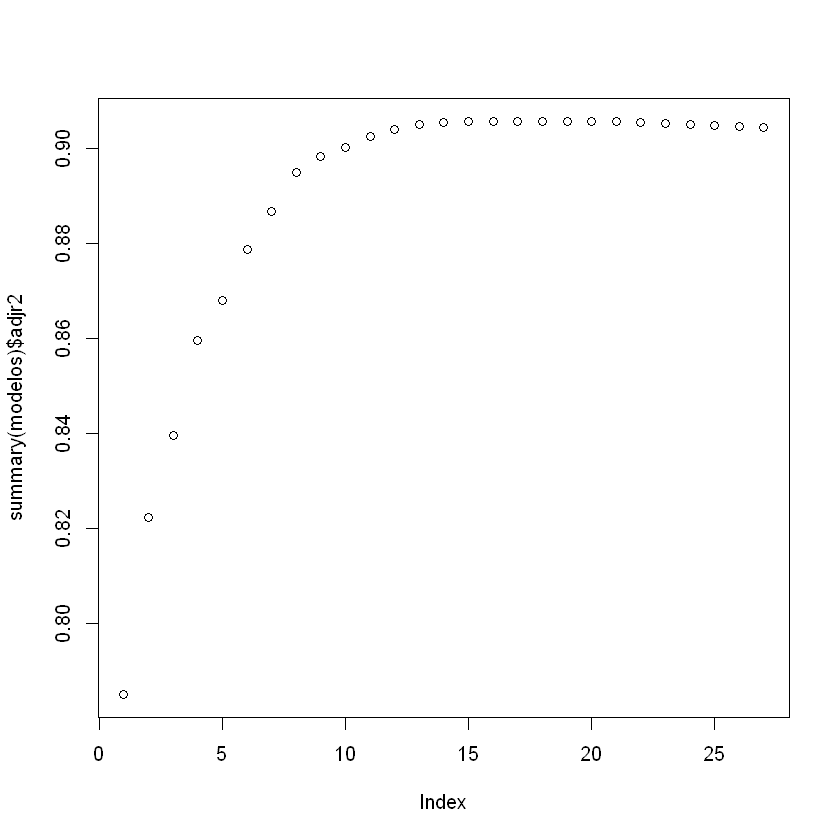

In [130]:
modelos <-
    regsubsets(y~(x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12)*x_NE+(x_NC+x_S),
               data = crimenes,
               nbest = 1,      
               nvmax = NULL,    
               method = "exhaustive",
               really.big=TRUE)
summary(modelos)
plot(summary(modelos)$adjr2)
which.max(summary(modelos)$adjr2)

Como se puede observar el mejor modelo es un modelo con 16 variables. Las cuales son: x1, x2, x6, x11, x12, x_NE, x_NC y las interacciones de NE con x1, x2, x4, x5, x6, x9, x10, x11 y x12. Ahora bien, dado que necesitamos la variable desempleo (x10) para hacer inferencias esa variable se deja. A continuación se muestra el nuevo modelo:

In [132]:
x1_NE <- x1 * x_NE
x2_NE <- x2 * x_NE
x4_NE <- x4 * x_NE
x5_NE <- x5 * x_NE
x6_NE <- x6 * x_NE
x9_NE <- x9 * x_NE
x10_NE <- x10 * x_NE
x11_NE <- x11 * x_NE
x12_NE <- x12 * x_NE
mejorModelo <- lm(y~x1+x2+x6+x10+x11+x12+x_NE+x_NC+x1_NE+x2_NE+x4_NE+x5_NE+x6_NE+x9_NE+x10_NE+x11_NE+x12_NE)
summary(mejorModelo)


Call:
lm(formula = y ~ x1 + x2 + x6 + x10 + x11 + x12 + x_NE + x_NC + 
    x1_NE + x2_NE + x4_NE + x5_NE + x6_NE + x9_NE + x10_NE + 
    x11_NE + x12_NE)

Residuals:
   Min     1Q Median     3Q    Max 
-87177  -4123     58   4283 195265 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.425e+04  8.350e+03  -1.706 0.088685 .  
x1          -1.083e+00  6.506e-01  -1.665 0.096648 .  
x2           1.277e-01  1.833e-02   6.967 1.25e-11 ***
x6           5.947e+00  1.168e+00   5.090 5.39e-07 ***
x10          3.246e+02  4.342e+02   0.748 0.455177    
x11          5.130e-01  3.919e-01   1.309 0.191281    
x12         -3.181e+00  8.158e-01  -3.899 0.000112 ***
x_NE        -1.118e+05  2.666e+04  -4.193 3.36e-05 ***
x_NC        -5.984e+03  2.153e+03  -2.780 0.005680 ** 
x1_NE       -1.420e+01  4.521e+00  -3.141 0.001802 ** 
x2_NE        3.549e-01  3.708e-02   9.572  < 2e-16 ***
x4_NE       -2.288e+03  7.034e+02  -3.253 0.001235 ** 
x5_NE       -7.511e+00  5.060e+

Como podemos ver nuestro modelo es globalmente significativo y cuenta con un $R^2_{ajustado}$=0.905 sin embargo podemos ver que hay variables que no son significativas individualmente por lo cual procedemos a sacarlas del modelo. El modelo resultante se presenta a continuación: 

In [134]:
mejorModelo2 <- lm(y~x6+x10+x12+x_NE+x_NC+x1_NE+x2_NE+x4_NE+x6_NE+x9_NE+x10_NE+x11_NE+x12_NE)
summary(mejorModelo2)


Call:
lm(formula = y ~ x6 + x10 + x12 + x_NE + x_NC + x1_NE + x2_NE + 
    x4_NE + x6_NE + x9_NE + x10_NE + x11_NE + x12_NE)

Residuals:
   Min     1Q Median     3Q    Max 
-89614  -4633    217   5382 196155 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.082e+03  3.088e+03  -1.970 0.049521 *  
x6           1.024e+01  1.079e+00   9.490  < 2e-16 ***
x10          8.995e+02  4.249e+02   2.117 0.034837 *  
x12          2.144e+00  1.881e-01  11.400  < 2e-16 ***
x_NE        -1.253e+05  2.694e+04  -4.652 4.39e-06 ***
x_NC        -7.623e+03  2.249e+03  -3.390 0.000763 ***
x1_NE       -1.521e+01  4.779e+00  -3.183 0.001566 ** 
x2_NE        5.090e-01  2.871e-02  17.728  < 2e-16 ***
x4_NE       -2.173e+03  7.468e+02  -2.909 0.003814 ** 
x6_NE       -4.025e+01  3.362e+00 -11.972  < 2e-16 ***
x9_NE        9.833e+03  1.078e+03   9.122  < 2e-16 ***
x10_NE      -4.372e+03  1.479e+03  -2.957 0.003282 ** 
x11_NE       5.525e+00  9.216e-01   5.995 4.33e-09 ***
x12_N

El nuevo modelo cuanta con todas las variables significativas incluído el $\beta_0$ y ademas cuenta con un $R^2_{ajustado}=0.892$ que como vemos es muy cercano al del primer modelo. 

Ya con nuesto modelo con las variables escogidas debemos verificar los supuestos del modelo. Primero se comienza verificando si existen o no datos influyentes y luego a partir del resultado se evaluar normalidad, autocorrelación, multicolinealidad y heteroscedasticidad. 

###### Outliers e Influyentes
Como primer paso se procede a revisar los datos outliers de manera gráfica mediante los residuos de la siguiente manera: 

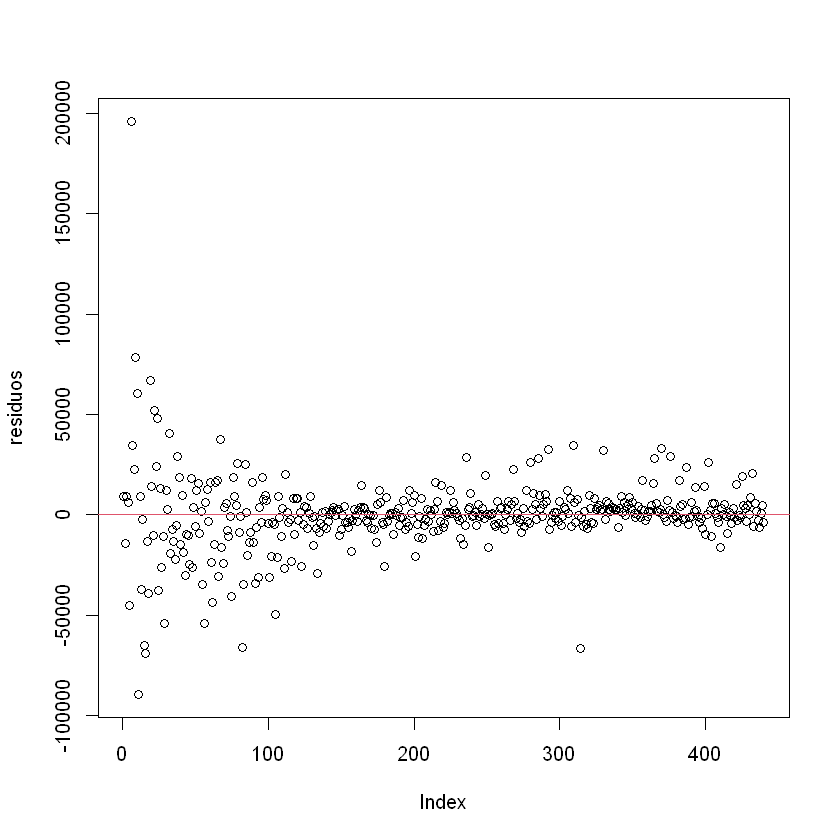

In [135]:
#Datos influyentes 
residuos <- mejorModelo2$residuals
plot(residuos)
abline(0,0, col=2)

En la anterior gráfica es posible observar que hay algunos datos (en especial un punto) que se encuentran alejados del cero, o de la linea roja, dado esto, se procede a realizar la comprobación estadística que empieza al estudentizar los residuos de la siguiente manera:

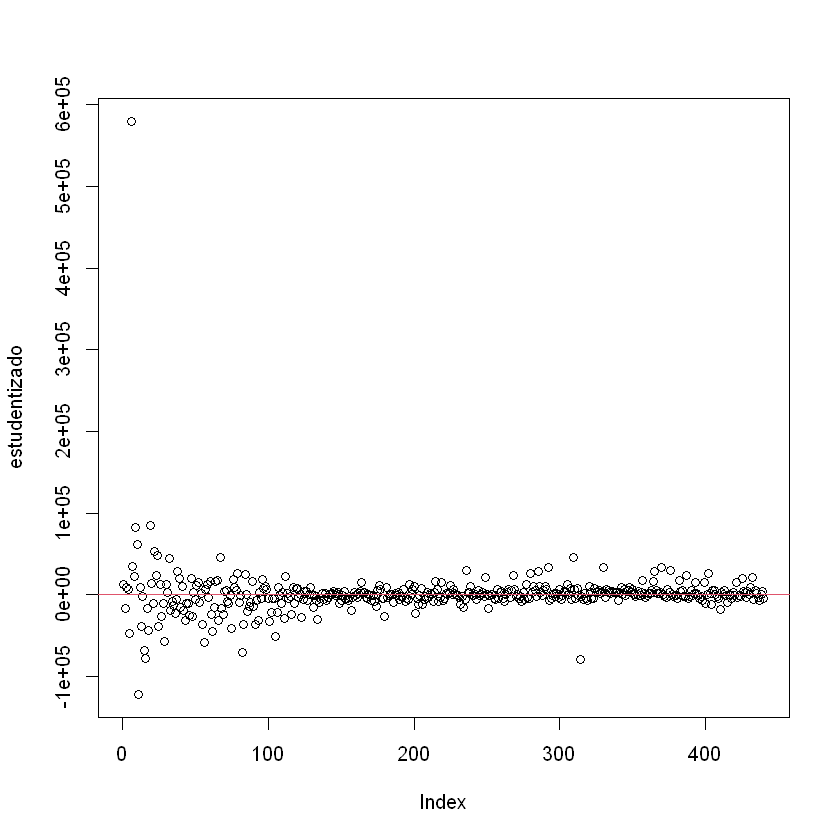

In [140]:

crimenes3 <- crimenes2[,-(1:5)] 
crimenes3 <- crimenes3[,-(3:5)]
crimenes3 <- crimenes3[,-4]
crimenes3 <- crimenes3[,-7]
crimenes3 <- cbind(crimenes3[],x1_NE,x2_NE,x4_NE,x6_NE,x9_NE,x10_NE,x11_NE,x12_NE)

#estudentizar 
x <- as.matrix(cbind(rep(1,), crimenes3))
H <- x %*% solve(t(x) %*% x) %*% t(x)
leve <- diag(H)

estudentizado <- residuos/sqrt(1-leve)
plot(estudentizado)                
abline(0,0,col=2)

Luego, con los datos estudentizados se procede a realizar el análisis de datos outliers e influyentes con el siguiente procedimiento, en donde se comprobará si hay datos outliers o no.

In [141]:
#Datos influyentes
p <- dim(crimenes3)[2]-1
n<-440
cd <- cooks.distance(mejorModelo2)
max(cd)
qf(0.5,p,n-p)
which(cd == max(cd))

[1] 36.6914

[1] 0.9507026

6 
6

In [142]:
crimenes3 <- crimenes3[-6,]

x6 <- crimenes3$x6
x10 <- crimenes3$x10
x12 <- crimenes3$x12
x_NE <- crimenes3$x_NE
x_NC <- crimenes3$x_NC
x1_NE <- crimenes3$x1_NE
x2_NE <- crimenes3$x2_NE
x4_NE <- crimenes3$x4_NE
x6_NE <- crimenes3$x6_NE
x9_NE <- crimenes3$x9_NE
x10_NE <- crimenes3$x10_NE
x11_NE <- crimenes3$x11_NE
x12_NE <- crimenes3$x12_NE

y <-crimenes3$y
mejorModelo3 <- lm(y~x6+x10+x12+x_NE+x_NC+x1_NE+x2_NE+x4_NE+x6_NE+x9_NE+x10_NE+x11_NE+x12_NE)
summary(mejorModelo3)


Call:
lm(formula = y ~ x6 + x10 + x12 + x_NE + x_NC + x1_NE + x2_NE + 
    x4_NE + x6_NE + x9_NE + x10_NE + x11_NE + x12_NE)

Residuals:
   Min     1Q Median     3Q    Max 
-65221  -3910     78   3367  78419 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.082e+03  1.740e+03  -3.495 0.000523 ***
x6           1.024e+01  6.081e-01  16.841  < 2e-16 ***
x10          8.995e+02  2.395e+02   3.757 0.000196 ***
x12          2.144e+00  1.060e-01  20.230  < 2e-16 ***
x_NE        -1.279e+04  1.563e+04  -0.818 0.413588    
x_NC        -7.623e+03  1.267e+03  -6.016 3.86e-09 ***
x1_NE       -4.523e+00  2.716e+00  -1.665 0.096627 .  
x2_NE        5.551e-02  2.205e-02   2.518 0.012182 *  
x4_NE       -8.620e+02  4.231e+02  -2.037 0.042228 *  
x6_NE       -6.839e+00  2.193e+00  -3.119 0.001940 ** 
x9_NE        1.779e+03  6.631e+02   2.683 0.007589 ** 
x10_NE      -7.696e+02  8.416e+02  -0.914 0.361051    
x11_NE       1.044e+00  5.400e-01   1.934 0.053765 .  
x12_N

In [143]:
p <- dim(crimenes3)[2]-1
n<-440-1
cd <- cooks.distance(mejorModelo3)
max(cd)
qf(0.5,p,n-p)

[1] 0.2098234

[1] 0.9507061

La prueba de la distancia de Cook arrojó un valor de 0.2098 que al compararlo con la distribución F(p,n-p)= 0.9507 se puede concluir con una significancia del 5% que no hay datos influyentes en el modelo, pues el valor máximo de Di es pequeño comparado con la mediana de la distribución F mencionada.

Como ya el modelo no tiene datos influyentes podemos ver que hay algunas variables que no son significativas individualmente por lo que procedemos a eliminarlas. Dejando como modelo resultante el que se muestra a continuación:

In [147]:
mejorModelo4 <- lm(y~x6+x10+x12+x_NC+x1_NE+x2_NE+x4_NE+x6_NE+x9_NE+x11_NE+x12_NE)
summary(mejorModelo4)


Call:
lm(formula = y ~ x6 + x10 + x12 + x_NC + x1_NE + x2_NE + x4_NE + 
    x6_NE + x9_NE + x11_NE + x12_NE)

Residuals:
   Min     1Q Median     3Q    Max 
-65327  -4016     88   3347  78506 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.781e+03  1.681e+03  -3.440 0.000639 ***
x6           1.026e+01  6.079e-01  16.871  < 2e-16 ***
x10          8.462e+02  2.294e+02   3.689 0.000254 ***
x12          2.143e+00  1.060e-01  20.222  < 2e-16 ***
x_NC        -7.598e+03  1.267e+03  -5.999 4.24e-09 ***
x1_NE       -5.545e+00  2.517e+00  -2.203 0.028103 *  
x2_NE        3.971e-02  1.830e-02   2.170 0.030568 *  
x4_NE       -1.113e+03  3.755e+02  -2.965 0.003195 ** 
x6_NE       -5.501e+00  1.972e+00  -2.790 0.005504 ** 
x9_NE        1.165e+03  4.960e+02   2.350 0.019251 *  
x11_NE       5.323e-01  2.156e-01   2.469 0.013957 *  
x12_NE      -2.726e+00  6.081e-01  -4.484 9.44e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual

Como se puede observar este modelo4 es globalmente significativo, y todas sus variables son individualmente significativas ademas tiene un $R^2_{ajustado}=0.9521 $

###### Multicolinealidad
Para ver si hay o no problemas de multicolinealidad lo primero que se decide hacer es graficar el comportamiento de las variables

x6       x10       x12      x_NC     x1_NE     x2_NE     x4_NE     x6_NE 
 7.145982  1.083894  6.956189  1.125342  2.989408 61.681162 18.694859 14.519058 
    x9_NE    x11_NE    x12_NE 
 8.891153 14.229471 39.528087

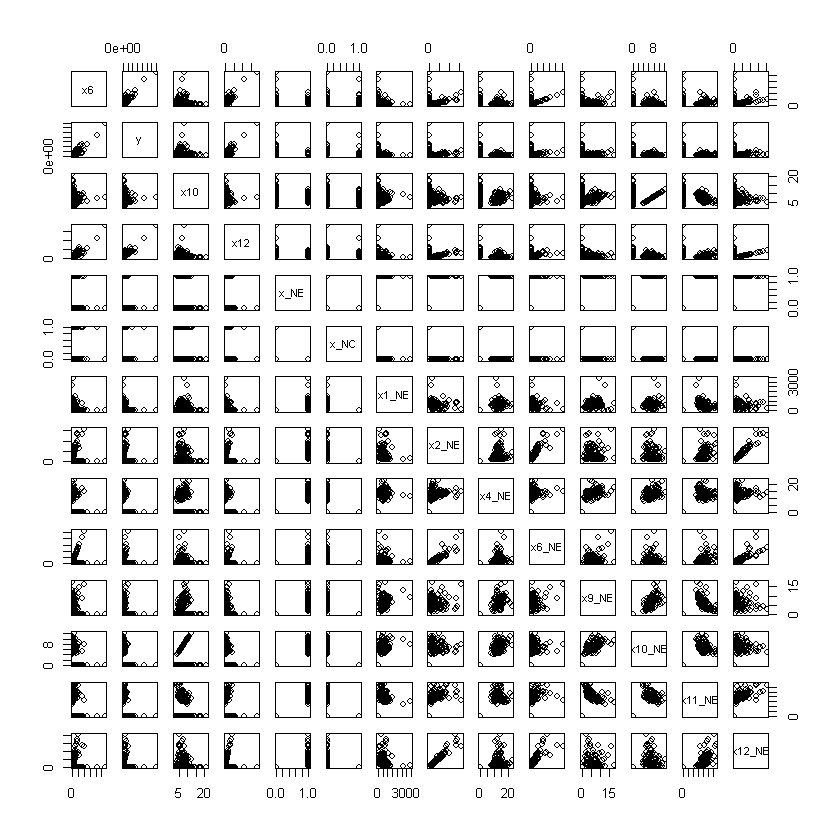

In [150]:
#Multicolinealidad
pairs(crimenes3)
vif(mejorModelo4)

Como se puede observar hay problemas de multicolinealidad y hay variables con VIF's muy altos por tal razón se decide eliminar algunas de ellas 

In [151]:
mejorModelo5 <- lm(y~x6+x10+x12+x_NC+x1_NE+x6_NE+x9_NE+x11_NE)
summary(mejorModelo5)
vif(mejorModelo5)


Call:
lm(formula = y ~ x6 + x10 + x12 + x_NC + x1_NE + x6_NE + x9_NE + 
    x11_NE)

Residuals:
   Min     1Q Median     3Q    Max 
-67485  -4221    412   4030  76555 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4936.7973  1733.1259  -2.848 0.004603 ** 
x6             11.1765     0.5998  18.633  < 2e-16 ***
x10           739.7248   236.4888   3.128 0.001880 ** 
x12             1.9658     0.1033  19.022  < 2e-16 ***
x_NC        -7919.4151  1311.0154  -6.041 3.33e-09 ***
x1_NE          -6.1188     2.5105  -2.437 0.015204 *  
x6_NE          -9.3504     0.8263 -11.316  < 2e-16 ***
x9_NE        1495.2618   346.3547   4.317 1.96e-05 ***
x11_NE         -0.4123     0.1133  -3.638 0.000308 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 11170 on 430 degrees of freedom
Multiple R-squared:  0.9494,	Adjusted R-squared:  0.9485 
F-statistic:  1009 on 8 and 430 DF,  p-value: < 2.2e-16


x6      x10      x12     x_NC    x1_NE    x6_NE    x9_NE   x11_NE 
6.470654 1.071659 6.156233 1.121617 2.766813 2.372262 4.032759 3.656198

Este nuevo modelo podemos ver que es globalmente significativos, que cada uno de sus variables es individualmente significativa y que no presenta problemas de multicolinealidad dado que todos los VIF's son < 10.

###### Normalidad
Para el caso del supuesto de normalidad lo primero que se hace es obtener los residuos y a partir de esto, se gráfica el ajuste a través de una Q-Q Plot como lo vemos a continuación:

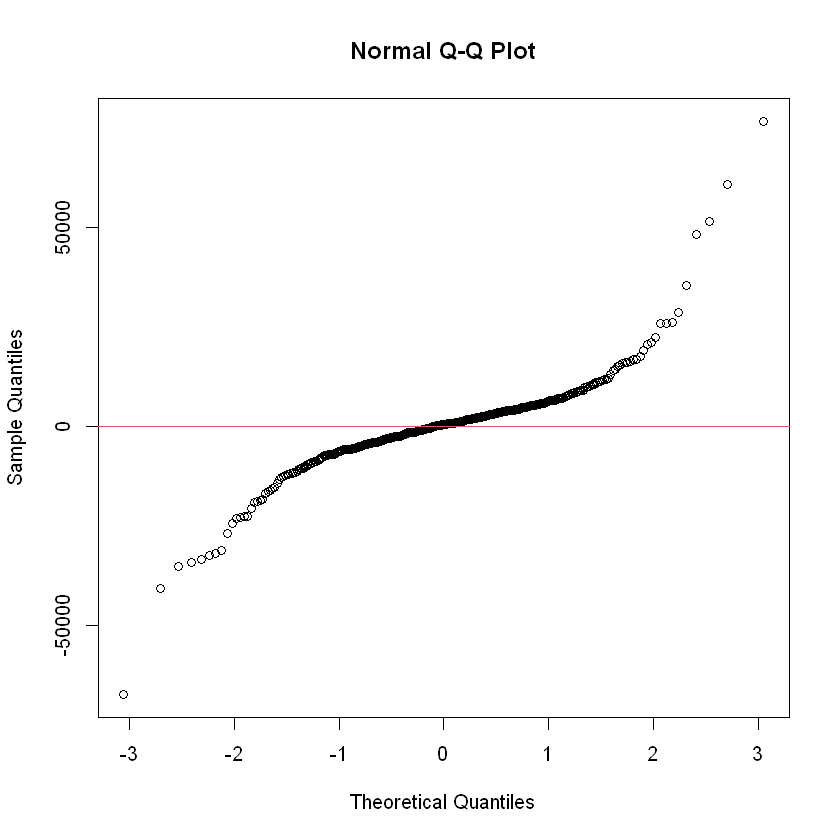

In [153]:
#Normalidad
residuosM <- mejorModelo5$residuals
qqnorm(residuosM)
abline(0,1,col=2)

En la anterior gráfica se puede ver que el comportamiento de los datos puede acercarse a una normal debido a que están muy cerca de la recta con pendiente 1 que pasa por el origen. (A excepción de 1 dato que parecería ser influyente)

Sin embargo, como es una observación gráfica, procedemos a comprobar lo anteriro de manera estadística por medio de la prueba Shapiro en donde se plantea la siguiente prueba de hipótesis:

$$
H_0: e_{i} \sim \ Normal
$$

$$
H_1:\lnot\ H_0
$$

In [154]:
#Normalidad - Shapiro 
shapiro.test(residuosM)


	Shapiro-Wilk normality test

data:  residuosM
W = 0.82621, p-value < 2.2e-16


Con un nivel de confianza del 95% no se rechaza la hipotesis nula, es decir que se puede concluir que los residuos del modelo se distribuyen normales dado que al realizar la prueba de Shapiro el p-value = 2.2e-16 lo cual es practicamente 0 por lo que es menor a 5%

###### Especificiadad
Se desea comprobar si el modelo está bien específicado o no. Para lo cual se realiza una prueba de Ramsey RESET test
En donde: 
$$
H_0= \text{No hay error de especificación}
$$
$$
H_1=\text{Sí hay error de especificación}
$$

In [155]:
library(lmtest)
reset(mejorModelo5,power=3)


	RESET test

data:  mejorModelo5
RESET = 3.3312, df1 = 1, df2 = 429, p-value = 0.06867


En la prueba podemos ver que el p-value es mayor 5%, lo que nos dice que no hay suficiente evidencia estadística, bajo una confiabilidad del 95% para rechazar la hipotesis nula. Es decir que el modelo no tiene problemas de específicación. 

#### 1.Revise si hay datos influyentes en el modelo. Puede explicar porqué son influyentes y si corresponden a errores de medición?

Tal como pudimos observar en el modelo si hay datos influyentes, en particular el dato no.6 que en este caso es un dato outlier que modifica drásticamente la recta de la regresión estimada por lo que se considera influyente. La prueba de la distancia de Cook nos mostró que estadísticamente ese era dato influyente. La forma de correguir ese dato fue eliminarlo y la misma prueba de la distancia de cook nos corroboró que habíamos eliminado el problema y ya no se tenían datos influyentes. Es posible que ese dato sea influyente por algún error de médición que se tuvo pero no necesariamente, la cantidad de crímenes totales era muy alto mientras que el resto de los valores eran promedios con respecto a las demás variables. 
Los datos influyentes se pueden presentar en efecto por errores de medición pero en este caso puntual, se debía más a los datos de una región en específico que generaban sesgo en los datos pues la cantidad de crimenes es muy alta cuando el resto de las variables está dentro de los rangos. 
Sin embargo al comprobar los demas supuestos y decidir eliminar algunas variables ya no se presentaron problemas de datos influyentes.

#### 2. Se quiere estimar el efecto que tiene el desempleo sobre el número total de crímenes serios, dado que se cree que existe una relación de causalidad. En un modelo que considere bien especificado, encuentre el efecto que tiene el desempleo sobre Y . Justifique su respuesta, y explique por qué considera que su modelo está bien especificado. En particular, revise que no tenga variables omitidas importantes.


Lo primero que se debe mencionar es que el modelo se encuentre bien específicado pues se escogieron las variables comparandolo con otros modelos, se comprobaron supuestos para mejorar y lo más importante al hacer la prueba de específicicación dió como resultado que no hay suficiente evidencia estadística, bajo una confiabilidad del 95% para rechazar la hipotesis nula. Es decir que el modelo no tiene problemas de específicación.

Recordemos entonces nuestro modelo resultante: 

$$
y=\beta_0+\beta_1x6+\beta_2x{10}+\beta_3x{12}+\beta_4x{NC}+\beta_5x{6_{NE}}+\beta_6x{9_{NE}}+\beta_7x{11_{NE}}+\epsilon
$$

Se quiere comprobar la siguiente prueba de hipótesis 

$$
H_0: \beta_2 = 0
$$

$$
H_1: \beta_2 \neq 0
$$

In [171]:
x<-cbind(x6, x10, x12, x_NC, x1_NE, x6_NE, x9_NE, x11_NE)

gtest <- function(x,y,A,c){
  n <- length(y)
  k <- dim(x)[2]
  p <- k + 1
  q <- dim(A)[1]
  xx <- cbind(rep(1,n), x)
  beta <- solve(t(xx) %*% xx) %*% t(xx) %*% y
  yhat <- xx %*% beta  
  mse <- sum((y - yhat)^2)/(n - p)
  betaH <- beta + solve(t(xx) %*% xx) %*% t(A) %*% solve(A %*% solve(t(xx) %*% xx) %*% t(A)) %*% (c- A %*% beta)
  yhatH <- xx %*% betaH
  F <- (sum((y- yhatH)^2)-sum((y- yhat)^2))/q /mse
  pval <- 1-pf(F, q, n- p)
  return(list(F = F, pvalue = pval))
}

A <- matrix(c(0,0,1,0,0,0,0,0,0),ncol=9,byrow = T)
c <-c(0)

gtest(x,y,A,c)

$F
[1] 9.78406

$pvalue
[1] 0.001879972

Con un nivel de confianza del 95% se puede concluir que se rechaza $H_0$, es decir que el efecto del desempleo sí influye en el número total de crimenes serios. Pues el ${p value}<5 \% $ . Lo anterior en términos de causalidad quiere decir que si se aumenta el desempleo, entonces se aumenta la cantidad de crimenes serios totales cometidos. 

No hay una prueba estadística que me indique si existen o no variables omitidas. Sin embargo se podría pensar en algunas variables que puede que no se estén teniendo en cuenta como la situación política o la cantidad de bandas criminales. 

## Parte C. Problemas aplicados con datos reales.

### Problema 4. Ventas de secadoras eléctricas en Bogotá.

#### 1. Revise todos los supuesto del modelo que sean pertinentes. Realice las pruebas que considere necesarias.

Los supuestos del modelo que se deberían revizar corresponde a  verificar normalidad, autocorrelación, multicolinealidad,  heteroscedasticidad y, tambien se debe verificar si existen o no datos outliers e influyentes. Dado lo anterior se realizan algunas pruebas correspondiente para evaluar cada uno de los supuestos presentados. 

Antes de comenzar se cargan los datos y se general em modelo de regresión lineal correspondiente y se debe comprobar la significancia del modelo

In [86]:
Secadoras <- read.table("Archivos/secadoras.txt", head = TRUE)
head(Secadoras)
data = Secadoras

y = Secadoras$ventas
x1 = Secadoras$precio
x2 = Secadoras$consumo
x3 = Secadoras$publicidad
x4 = Secadoras$competencia

##Modelo
Reg = lm(y ~ x1 + x2 + x3 + x4)
summary(Reg)

,ventas,precio,consumo,publicidad,competencia
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-51.86530,12.730041,5.120954,7.883980,3.358127
2,-24.59515,12.923566,9.128683,9.978578,8.737131
3,-30.71430,7.123548,8.091998,9.577806,2.688939
4,-39.84182,10.145909,7.104766,10.780311,5.617165
5,-60.28946,11.641656,6.877741,9.192014,1.909947
6,-64.63831,12.139542,7.248237,7.045200,2.517575



Call:
lm(formula = y ~ x1 + x2 + x3 + x4)

Residuals:
    Min      1Q  Median      3Q     Max 
-53.310  -7.222  -1.668   9.079  38.884 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  19.1644    12.9062   1.485  0.14289    
x1           -3.7720     0.8316  -4.536 2.87e-05 ***
x2           -9.0379     0.9525  -9.488 1.77e-13 ***
x3            3.0562     1.0849   2.817  0.00658 ** 
x4            2.9156     0.9476   3.077  0.00317 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15.73 on 59 degrees of freedom
Multiple R-squared:  0.6911,	Adjusted R-squared:  0.6702 
F-statistic:    33 on 4 and 59 DF,  p-value: 1.901e-14


Según lo observado, con un nivel de significancia del 5%, se concluye que el modelo es globalmente significativo y que todas sus variables son individualmente significativas. Sin embargo, el intercepto no es significativo.

###### Outliers e Influyentes
Como primer paso se procede a revisar los datos outliers de manera gráfica mediante los residuos de la siguiente manera: 

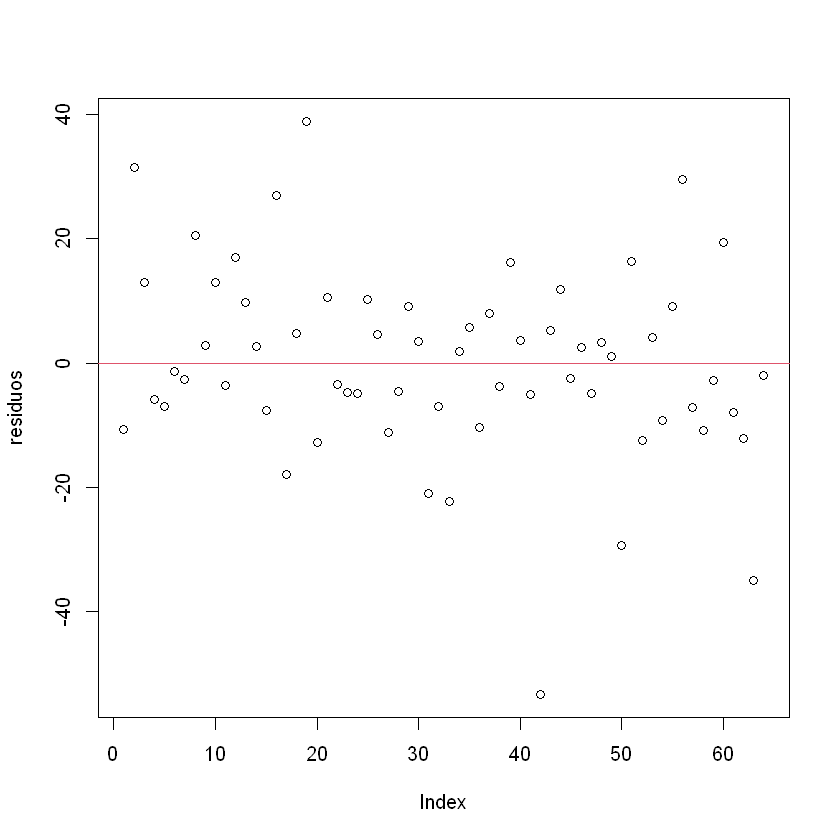

In [87]:
#Residuales
plot(residuos)
abline(0,0, col=2)

En la anterior gráfica es posible observar que hay algunos datos (puntos) que se encuentran alejados del ceo, o de la linea roja, dado esto, se procede a realizar la comprobación estadística que empieza al estudentizar los residuos de la siguiente manera:

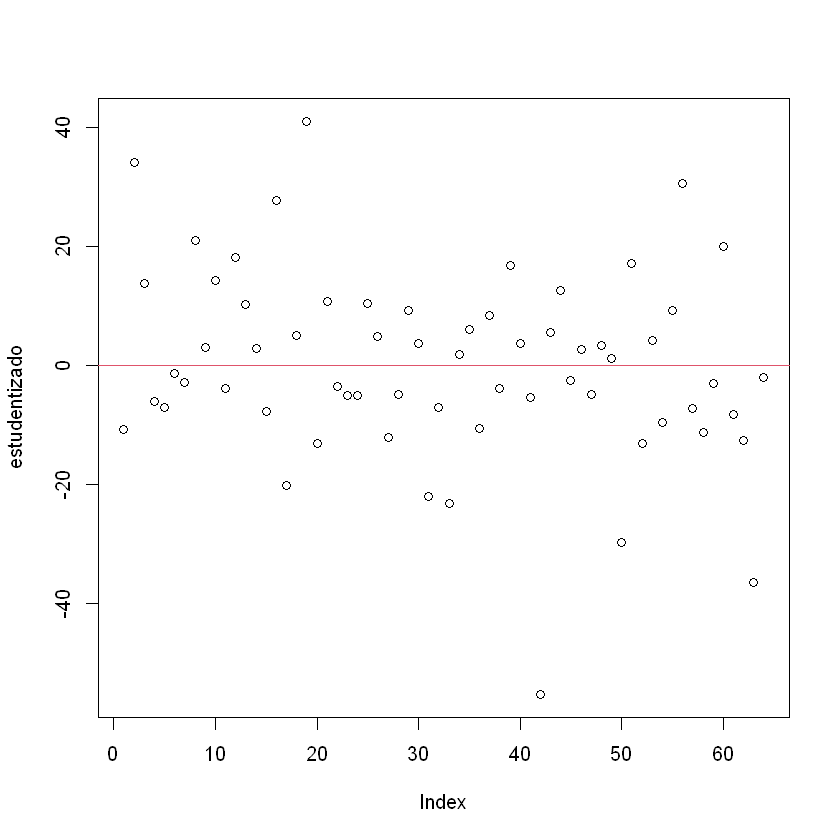

In [88]:
#estudentizar 
es <- Reg$residuals
x <- as.matrix(cbind(rep(1,dim(data)[1]),data[,2:5]))
H <- x%*%solve(t(x)%*%x)%*%t(x)
leve <- diag(H)

estudentizado <- Res/sqrt(1-leve)
plot(estudentizado)                
abline(0,0,col=2) 

Al ver las gráficas se puede pensar en que sí hay indicios de datos outliers pero se debe comprobar si en efecto hay datos outliers o no.

In [89]:
#estudentizar 
p <- dim(secadoras)[2]-1
n <- length(x1)
ValorComparar <- (2*p)/n
max(leve)
ValorComparar 

[1] 0.2141463

[1] 0.125

In [91]:
# Datos outliers
t <- Res*sqrt((n-p-1)/(sum((y-predict(Reg))^2)*(1-leve)-Res^2))
max(t)
qt(0.95,n-p-1)

[1] 2.77419

[1] 1.671093

Se evalúa la existencia de datos influyentes con un valor de 2.7741 contra una $t_{59}$=1.671 y se puede concluir con un nivel de confianza del 95% que existen datos outliers dado que EP < t.

In [92]:
# Datos influyentes - Distancia de Cook
cd <- cooks.distance(modelo)
max(cd)
qf(0.5,p,n-p)

[1] 0.193887

[1] 0.8487321

La prueba utilizada para saber si hay o no datos atipicos fue la distancia de Cook. La cual arrojó un valor de 0.1939 que al compararlo con la distribución F(p,n-p)=0,8487 se puede concluir con una significancia del 5% que no hay datos influyentes en el modelo, pues el valor de Di no es lo suficiente mente grande comparado con la mediana de
la distribución F mencionada. 

###### Normalidad
Para el caso del supuesto de normalidad lo primero que se hace es obtener los residuos y a partir de esto, se gráfica el ajuste a través de una Q-Q Plot como lo vemos a continuación:

In [ ]:
#Normalidad
residuos <- modelo$residuals
qqnorm(residuos)
abline(0,1,col=2)

En la anterior gráfica se puede ver que el comportamiento de los datos no es normal debido a que están muy lejanos de la recta con pendiente 1 que pasa por el origen. 

Sin embargo, como es una observación gráfica, procedemos a comprobar lo anteriro de manera estadística por medio de la la prueba Shapiro en donde se plantea la siguiente prueba de hipótesis:

$$
H_0: e_{i} \sim \ Normal
$$

$$
H_1:\lnot\ H_0
$$


In [ ]:
#Normalidad - Shapiro 
shapiro.test(residuos)

Con un nivel de confianza del 95% se rechaza la hipotesis nula, es decir que se puede concluir que los residuos del modelo no se distribuyen normales dado que al realizar la prueba de Shapiro el p-value = 0.04867 lo cual es menor a 5%

###### Autocorrelación
Para evaluar si hay o no autocorrelación entre los datos del modelo se decir realizar dos pruebas, la primera es la prueba de Durbin-Watson y la segunda la de Breusch-Godfrey.

* Prueba Durbin-Watson:
$$
H_0:\rho=0
$$

$$
H_1: \rho>0
$$


In [95]:
#Autocorrelacion
dwtest(modelo)

Como se puede ver, el resultado de la prueba de Durbin.Watson arrojó un p-value = 0.7863, por lo que no se rechaza la hipotesis nula dado que el p-value > 5%, es decir que con una confianza del 95% que no hay problemas de autocorrelación. 



* Prueba Breusch-Godfrey:
$$
H_0: \rho_i=0  \ \ \forall \ i\in N
$$

$$
H_1:\lnot\ H_0
$$

In [ ]:
#Autocorrelacion
bgtest(modelo)

Como se puede ver, el resultado de la prueba de Breusch-Godfrey arrojó un p-value = 0.4284, por lo que no se rechaza la hipotesis nula dado que el p-value > 5%, es decir que con una confianza del 95% que no hay problemas de autocorrelación. 


Es claro, por las dos pruebas realizadas que se puede concluir que los datos cumplen con el supuesto de la no autocorrelación. 

###### Multicolinealidad
Para ver si hay o no problemas de multicolinealidad lo primero que se decide hacer es graficar el comportamiento de las variables

In [97]:
#Multicolinealidad
pairs(secadoras[,2:5])

Gráficamente no es claro que haya una tendencia entre los datos, pues se ve que las nubes de puntos no tienen una tendencia aparente, es decir que se puede pensar que no hay problemas de multicolinealidad. Sin embargo, para estar seguros se decide obtener los VIF del modelo. Si se llega a obtener algun VIF con un valor muy grande (aprox. mayor a 10) se considera que hay problemas de multicolinealidad. 

In [98]:
vif(modelo)

Como se puede ver en cada uno de los VIF, ninguno es mayor a 10, en realidad son valores muy bajos pues no sobre pasan el 1.2, por tal motivo se puede concluir que el modelo no tiene problemas de multicolinealidad. 

###### Heterocedasticidad
Se procede ahora a evaluar el supuesto de homocedasticidad, para esto se realiza la prueba de Breusch-Pagan que consiste en evaluar el siguiente modelo:
$$
e_{i^2}=\alpha_0+\alpha_1X_{1i}+\alpha_2X_{2i}+\alpha_3X_{3i}+\alpha_4X_{4i}+w_i
$$

y se plantea la siguiente prueba de hipotesis: 
$$
H_0: \alpha_1 = \alpha_2 =\alpha_3 =\alpha_4= 0
$$

$$
H_1:\exists i \in \{1,2,3,4\} | \alpha_i \neq 0
$$

In [ ]:
#Heteroscedasticidad
bptest(modelo)

Al realizar la prueba se puede concluir que con un nivel de confianza del 95% hay suficiente evidencia estadística para rechazar $H_0$, es decir que efectivamente hay problemas de heteroscedasticidad, dado que el p-value es 0.03641 lo cual es menor a 5% que es el nivel de significancia. 

Dado que se encontró problemas de heteroscedasticidad, se realizó la evaluación de las variables en las cuales se encuentran problemas de heteroscedasticidad dentro del modelo:

In [ ]:
residuos2 <- residuos^2
n <- length(y)

model1 <- lm(residuos2~precio) 
pvalor1 <- 1-pchisq(n*summary(model1)$r.squared,1)

model2 <- lm(residuos2~consumo) 
pvalor2 <- 1-pchisq(n*summary(model2)$r.squared,1)

model3 <- lm(residuos2~publicidad) 
pvalor3 <- 1-pchisq(n*summary(model3)$r.squared,1)

model4 <- lm(residuos2~competencia) 
pvalor4 <- 1-pchisq(n*summary(model4)$r.squared,1)

pvalores <- c(pvalor1,pvalor2,pvalor3,pvalor4)
pvalores

Al observar los p-values de cada una de las variables se puede concluir que las variables de Consumo y Competencia son las que están generando los problemas de heteroscedasticidad esto dado que los p-value de estas dos variables son menores a nuestro nivel de significancia del 5%. 

###### Independencia
Para corroborar si los datos son independiente se realiza la prueba de Durbin-Watson


	Durbin-Watson test

data:  Reg
DW = 2.1838, p-value = 0.7863
alternative hypothesis: true autocorrelation is greater than 0


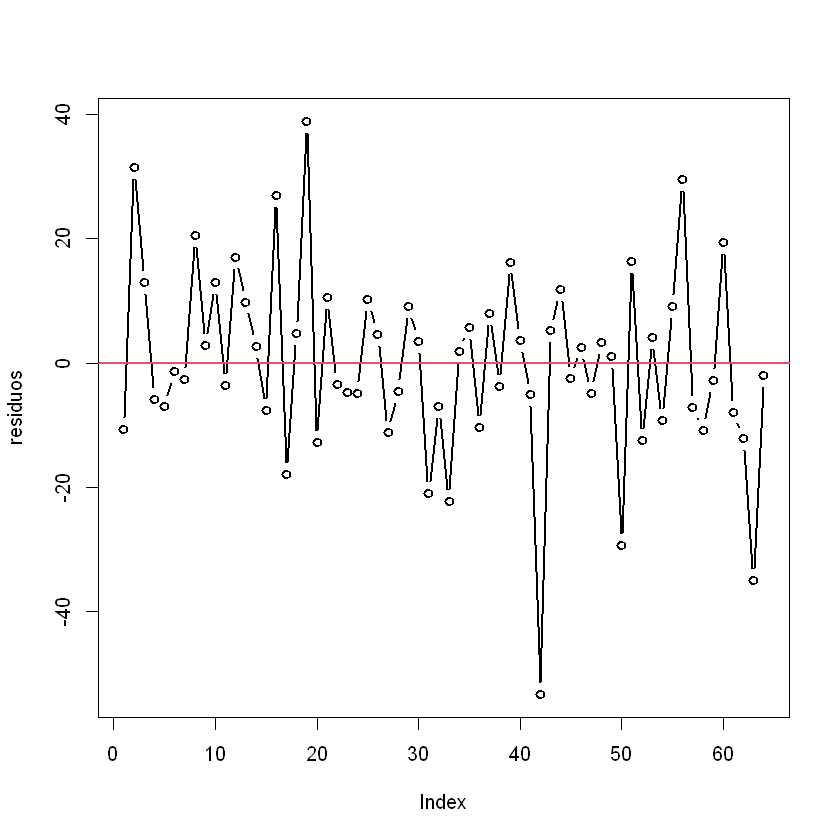

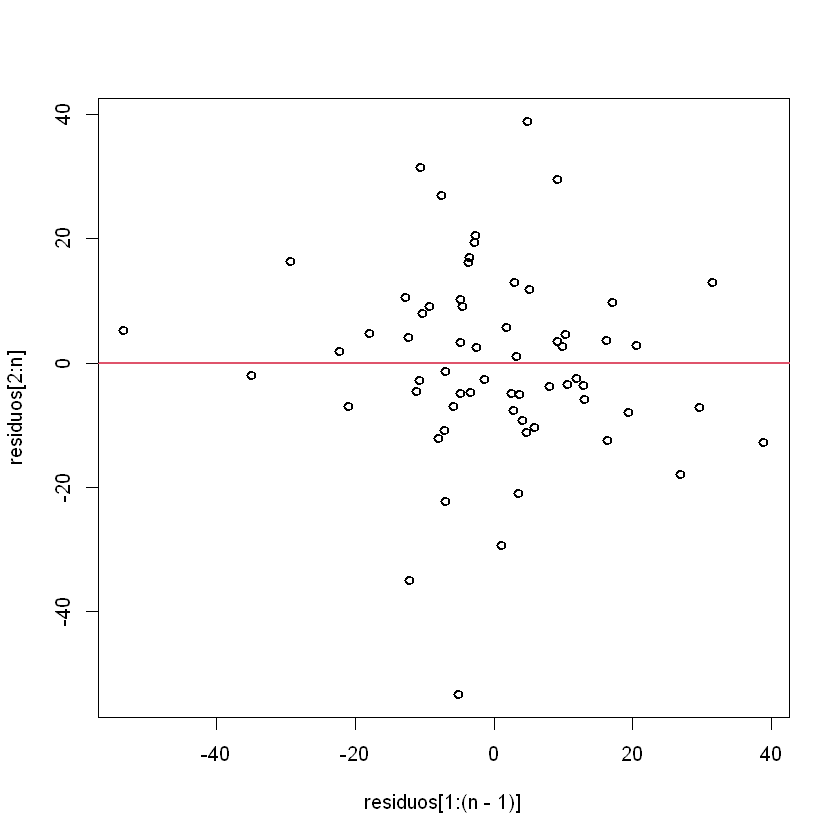

In [101]:
dwtest(Reg)
plot(residuos,type="b",lwd=2)
abline(0,0, col=2, lwd=2)
plot(residuos[1:(n-1)],residuos[2:n],lwd=2)
abline(0,0, col=2, lwd=2)

Tanto con las gráficas como con la prueba se puede concluir bajo un nivel de significancia del 5% que no se rechaza la hipótesis nula por lo que el coeficiente de autocorrelación es cero y por lo tanto no se viola el supuesto de independencia. 

#### 2. Encuentre una manera de solucionar el problema de las varianzas.

Lo primero es recordar la prueba de heterocedasticidad, es decir la pruena de Breusch-Pagan que consiste en evaluar el siguiente modelo:
$$
e_{i^2}=\alpha_0+\alpha_1X_{1i}+\alpha_2X_{2i}+\alpha_3X_{3i}+\alpha_4X_{4i}+w_i
$$

y se plantea la siguiente prueba de hipotesis: 
$$
H_0: \alpha_1 = \alpha_2 =\alpha_3 =\alpha_4= 0
$$

$$
H_1:\exists i \in \{1,2,3,4\} | \alpha_i \neq 0
$$

In [102]:
#Heteroscedasticidad
bptest(modelo)


	studentized Breusch-Pagan test

data:  modelo
BP = 10.251, df = 4, p-value = 0.03641


Al realizar la prueba se puede concluir que con un nivel de confianza del 95% hay suficiente evidencia estadística para rechazar $H_0$, es decir que efectivamente hay problemas de heteroscedasticidad, dado que el p-value es 0.03641 lo cual es menor a 5% que es el nivel de significancia. 

Dado que se encontró problemas de heteroscedasticidad, se realizó la evaluación de las variables en las cuales se encuentran problemas de heteroscedasticidad dentro del modelo:

In [103]:
residuos2 <- residuos^2
n <- length(y)

model1 <- lm(residuos2~precio) 
pvalor1 <- 1-pchisq(n*summary(model1)$r.squared,1)

model2 <- lm(residuos2~consumo) 
pvalor2 <- 1-pchisq(n*summary(model2)$r.squared,1)

model3 <- lm(residuos2~publicidad) 
pvalor3 <- 1-pchisq(n*summary(model3)$r.squared,1)

model4 <- lm(residuos2~competencia) 
pvalor4 <- 1-pchisq(n*summary(model4)$r.squared,1)

pvalores <- c(pvalor1,pvalor2,pvalor3,pvalor4)
pvalores

[1] 0.90603417 0.02492710 0.65430577 0.02274397

Al observar los p-values de cada una de las variables se puede concluir que las variables de Consumo y Competencia son las que están generando los problemas de heteroscedasticidad esto dado que los p-value de estas dos variables son menores a nuestro nivel de significancia del 5%. 

Para solucionar el problema de las varianzas se debe tener en cuenta que las variables donde se demostró que había los problemas eran: consumo y competencia. Por lo que para solucionarlo se procede a utilizar Mínimos Cuadrados Ponderados Factibles (FWLS). 

Lo primero que se debe hacer es calcular la matriz:
$$
\hat{\Omega}=\left[\begin{matrix}{\hat{\sigma}}_1^2&\cdots&0\\\vdots&\ddots&\vdots\\0&\cdots&{\hat{\sigma}}_n^2\\\end{matrix}\right]
$$
Para poder encontrar los betas y las varianzas se emplean las siguientes ecuaciones:
$$
{\hat{\beta}}_{FWLS}=(X^T {\hat{\Omega}}^{-1} X)^{-1}(X^T {\hat{\Omega}}^{-1} Y)
$$

$$
{\widehat{Var}}_{FWLS}=(X^T {\hat{\Omega}}^{-1} X)^{-1}((X^T \hat{\Lambda} X))(X^T {\hat{\Omega}}^{-1} Y)^{-1}
$$

Sabiendo que:
$$
\hat{\Lambda}=\left[\begin{matrix}\frac{\left(e_{j_1}\right)^2}{\left({\hat{\sigma}}_1^2\right)^2}&\cdots&0\\\vdots&\ddots&\vdots\\0&\cdots&\frac{\left(e_{j_n}\right)^2}{\left({\hat{\sigma}}_n^2\right)^2}\\\end{matrix}\right]
$$

In [104]:
fit <- lm(y~x1 + x2 + x3 + x4)
x <- as.matrix(cbind(rep(1,n), data[,2:5]))
x22 <- as.matrix(cbind(rep(1,n), data[,3]))
logResiduos2 <- log(residuos2)
regresionlog <- lm(logResiduos2~x2)
summary(regresionlog)


Call:
lm(formula = logResiduos2 ~ x2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5056 -1.0302  0.0569  1.0845  3.4462 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  2.40209    0.70245   3.420  0.00111 **
x2           0.24809    0.09814   2.528  0.01404 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.672 on 62 degrees of freedom
Multiple R-squared:  0.09344,	Adjusted R-squared:  0.07882 
F-statistic:  6.39 on 1 and 62 DF,  p-value: 0.01404


Con el modelo de los residuales al cuadrado y calculado el logaritmo de esos residuales al cuadrado se procede a calcular $\hat{\sigma}^2 = exp(x_2*\alpha)$

In [105]:
alpha <- regresionlog$coefficients
yhat <- exp(x22 %*% alpha)
sigma2 <- diag(as.numeric(yhat))
Omega <- sigma2
xwx <- solve(t(x) %*% solve(Omega) %*% x)

betasFWLS <- (xwx) %*% t(x) %*% solve(Omega) %*% y

Con lo anterior ya se tiene todo lo necesario para calcular los ${\hat{\beta}}_{FWLS}$

In [106]:
library(lmtest)
resinew <- (y - x %*% betasFWLS)^2
aux <- lm(resinew ~ x1 + x2 + x3 + x4)
v <- matrix(rep(0,64*64),ncol=64)
v <- diag(as.numeric(resinew / diag(Omega^2)))
xv <- t(x) %*% v %*% x
varFWLS <- xwx %*% xv %*% xwx
diag(varFWLS)
varFWLS

rep(1, n)      precio     consumo  publicidad competencia 
 61.8765896   0.3972577   0.7437502   0.6646581   0.7032191

,"rep(1, n)",precio,consumo,publicidad,competencia
"rep(1, n)",61.8765896,-2.4217174,-0.4465377,-4.0217233,0.7171486
precio,-2.4217174,0.3972577,-0.2739401,0.0149117,-0.3346344
consumo,-0.4465377,-0.2739401,0.7437502,-0.1847683,0.4873066
publicidad,-4.0217233,0.0149117,-0.1847683,0.6646581,-0.1647921
competencia,0.7171486,-0.3346344,0.4873066,-0.1647921,0.7032191


Con el nuevo modelo se debe comprobar que se logró correguir el problema de la heterocedasticidad, por lo que se porcede a lo siguiente: 

In [107]:
logerror <- predict(regresionlog)
error <- exp(logerror)

modelonew <- lm(y~ x1 + x2 + x3 + x4, weights = 1/error)
summary(modelonew)

resinew2 <- modelonew$residuals^2
modelobp <- lm(resinew2~x1 + x2 + x3 + x4)
bptest(modelobp)


Call:
lm(formula = y ~ x1 + x2 + x3 + x4, weights = 1/error)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-5.8604 -0.9888 -0.1396  1.2362  4.0739 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  18.5547    11.0620   1.677 0.098769 .  
x1           -4.2095     0.7203  -5.844 2.34e-07 ***
x2           -8.1084     0.9022  -8.988 1.20e-12 ***
x3            3.0404     0.9873   3.080 0.003145 ** 
x4            2.9430     0.7925   3.714 0.000455 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.819 on 59 degrees of freedom
Multiple R-squared:  0.7253,	Adjusted R-squared:  0.7067 
F-statistic: 38.94 on 4 and 59 DF,  p-value: 6.267e-16



	studentized Breusch-Pagan test

data:  modelobp
BP = 4.2568, df = 4, p-value = 0.3724


Con este p-value = 0.3724 que es mayor a 5%, se puede concluir que el modelo ya no presenta problemas de heteroscedasticidad con un nivel de confianza del 95% dado que no se rechaza $H_0$.

#### 3. Un reconocido economista afirma que el efecto del precio es el mismo que el de la competencia pero son signo contrario, y además que el efecto del consumo de energía es cuatro veces que el del gasto en publicidad con signo contrario. Cree Usted que los datos contradicen la afirmación del economista? Use al menos dos formas diferentes adecuadas para probar esta hipótesis

El primer método para probar si la afirmación del economista es cierta o no, es una prueba de Wald con la siguiente prueba de hipótesis:
$$
H_0:\ \ \ \left\{\begin{matrix}\beta_{1\ \left(FWLS\right)}+\beta_{4\ \left(FWLS\right)}=0\\\beta_{2\ \left(FWLS\right)}+4{\cdot\beta}_{3\ \left(FWLS\right)}=0\\\end{matrix}\right.
$$

$$
H_1:\ \ \ \lnot\ H_0
$$



In [109]:
a <- matrix(c(0,1,0,0,1,0,0,1,4,0),ncol=5,byrow = T)
EP <- t(a %*% betasFWLS) %*% solve(a %*% varFWLS %*% t(a)) %*% (a %*% betasFWLS)
EP
wcr <- qchisq(0.95,2) 
wcr
pvalue <- 1-pchisq(EP,2)
pvalue

4.611612


[1] 5.991465

0.09967841


Como se puede observar el valor del estadístico de prueba es $EP = 4.6116$ y el $w_{cr}=5.9915$ y el $p-value =0,0997$. Cómo el $EP<w_{cr}$ y p-value>5% entonces se puede concluir, bajo un nivel de confianza del 95% que no se rechaza la $H_0$, por lo cual no hay suficiente evidencia estadística para rechazar la afirmación del economista.

Otro método que se puede utilizar para probar si la afirmación del economísta es correcta o no es el método de Bootstrap. Mediante este método se realizan remuestreos de las observaciones de la base de datos y se saca FWLS para cada uno de los conjuntos creados de la siguiente manera:

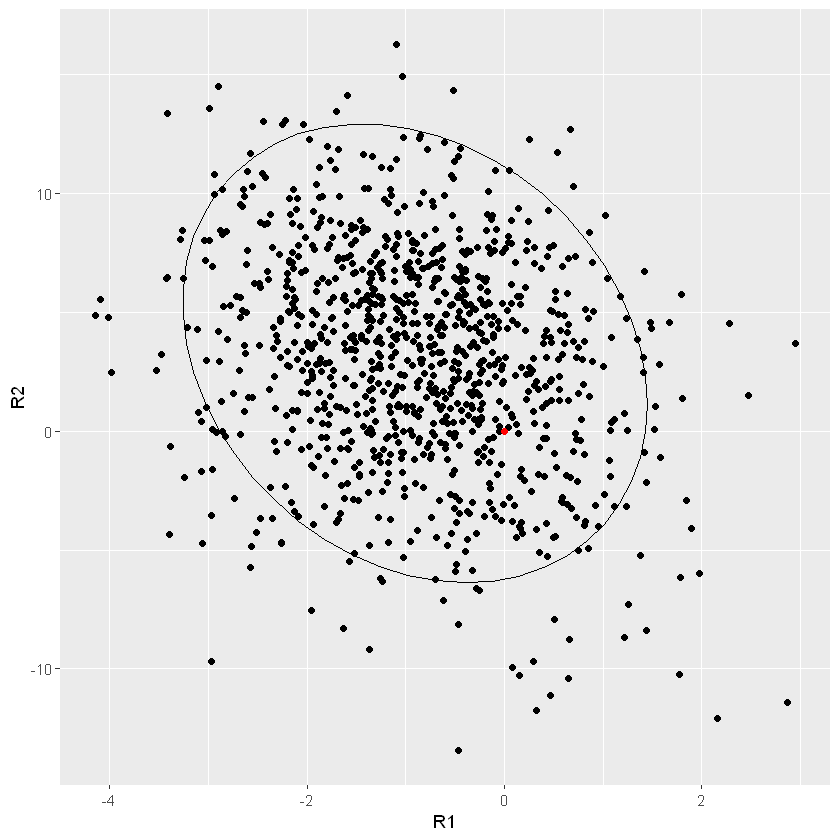

In [110]:
##Bootstrap
nn <- 1000
B_Boot <- matrix(rep(0,nn * 5),ncol = 5)

for(i in 1:1000){
  id <- sample(seq(1:64),64,replace = T)
  xs <- X[id,]
  ys <- y[id]
  beta_R <-solve(t(xs)%*%solve(Omega)%*%xs)%*%(t(xs)%*%solve(Omega)%*%ys)
  B_Boot[i,] <-beta_R
}
    
library(ggplot2) 
R1 <- B_Boot[,2] + B_Boot[,5]
R2 <- B_Boot[,3] + 4 * B_Boot[,4]
HE <- data.frame(R1,R2)
ggplot(HE, aes(R1,R2))+geom_point()+stat_ellipse()+geom_point(aes(0,0), col="red")                                   


Dado que el punto 𝑐 = (0,0) cae dentro de la elipse de confianza, se puede concluir que los datos no contradicen la afirmación del economista bajo un nivel de confianza del 95%.

### Problema 5. Efectos de medidas preventivas en la severidad del coronavirus.

Una de las preguntas más comunes en política de salud pública en la actualidad, es determinar el efecto de las medidas de restricción de movilidad o de actividades que impliquen reducir el contacto entre personas. Esto es por ejemplo, las cuarentenas, el pico y cédula, la prohibición de clases presenciales, uso de tapabocas, etc. Por conveniencia, estas medidas han sido agrupadas en una sola métrica conocide con el _Stringency Index_. Para entender cómo se calcula, puede revisar los documentos relacionados en: https://covidtracker.bsg.ox.ac.uk/.

En un modelo simplificado, se quiere probar el efecto de esta medidas en Colombia (usando el _stringency
index_) sobre la tasa de mortalidad usando el modelo:

$$
    \log(MR_t) = \beta_0 + \beta_1 SI_t + \beta_2 \log(NC_t) + \varepsilon_t
$$

Donde $MR_t$ corresponde a la tasa de mortalidad (número de muertes por Covid por cada millón de habitantes) en el día $t$, $NC_t$ corresponde al número de casos confirmados (por cada millón de habitantes) durante los últimos 14 días antes de $t$, y $SI_t$ corresponde al promedio del _stringency index_ para los 14 días anteriores a $t$, es decir:

$$
    SI_t = \frac{\sum_{i = 1}^{14}strind_{t-i}}{14},
$$

$$
    NC_t = \sum_{i = 1}^{14} nc_t.
$$

$strind_t$ es la medida del _stringency index_ en el día $t$ y $nc_t$ es el número de casos confirmados en el día $t$. Para evitar problemas con los logaritmos, cuando las variables $MR_t$ o $NC_t$ tomen el valor de cero, entonces aproxímelos como 1. Si considera que en la base da datos existen variables importantes para tener un modelo mejor específicado, no dude en incluirlas.

Note que este modelo es definido sobre series de tiempo. Como periodo de estudio, use datos desde el noviembre 1 del 2020 hasta noviembre 1 de 2021. Para obtener los datos de las variables, puede revisar: https://ourworldindata.org/grapher/covid-stringency-index.

In [12]:
library(readr)
data_ <- read_csv("Archivos/owid-covid-data-filtered.csv", show_col_types = FALSE)

data <- data_[15:nrow(data_), "new_deaths_per_million"]

for (i in seq_len(nrow(data_))[-(1:14)]) {
    if (data[i - 14, "new_deaths_per_million"] < 1) {
        data[i - 14, "new_deaths_per_million"] <- 1
    }
    
    data[i - 14, "SI_t"] <- mean(data_[(i-14):(i-1), ]$stringency_index)
    
    data[i - 14, "NC_t"] <- sum(data_[(i-14):(i-1), ]$new_cases_per_million)
    if (data[i - 14, "NC_t"] <= 1) {
        data[i - 14, "NC_t"] <- 1
    }
}

head(data)

new_deaths_per_million,SI_t,NC_t
<dbl>,<dbl>,<dbl>
3.894,65.74,2264.138
3.701,65.74,2225.101
3.046,65.74,2158.324
3.508,65.74,2153.986
3.817,65.74,2118.921
3.239,65.74,2072.578


#### 1. Estime los parámetros del modelo e interpréte los intervalos de confianza correspondientes. Tenga en cuenta los logaritmos. ¿Encuentra coherencia en los resultados?

In [11]:
modelo_init <- lm(log(new_deaths_per_million) ~ SI_t + log(NC_t), data = data)
summary(modelo_init)
confint(modelo_init)


Call:
lm(formula = log(new_deaths_per_million) ~ SI_t + log(NC_t), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.55355 -0.09737  0.00437  0.10580  0.70630 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.3492321  0.0772420  -69.25  < 2e-16 ***
SI_t         0.0031804  0.0007519    4.23 2.99e-05 ***
log(NC_t)    0.8499202  0.0107637   78.96  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1718 on 349 degrees of freedom
Multiple R-squared:  0.9571,	Adjusted R-squared:  0.9569 
F-statistic:  3895 on 2 and 349 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
(Intercept),-5.501150474,-5.197313653
SI_t,0.001701668,0.004659223
log(NC_t),0.828750351,0.871090144


El modelo parece ser globalmente y marginalmente significativo. También presenta un buen $R^{2}$ y $R^{2}_{\text{adj}}$, lo que indica que tiene buen poder predictivo. Falta validar los suspuestos.

Si tomamos literalemente por su significado los coeficientes, el modelo no tiene mucho sentido. Este sugiere que cuando en los últimos 14 días no han habido casos y no han habido medidas de mitigación ($SI_t = 0$), se logra una cantidad negativa de muertes por cada millon de habitantes. También sugiere, aunque por un coeficiente muy pequeño, que la tasa de mortalidad crece con el promedio de los últimos 14 días del _stringency index_, lo cual tiene poco sentido ya que se esperaría una disminución en las fatalidades por COVID, dadas restricciones más cautelosas. 

#### 2. ¿Considera que el modelo tiene problemas de heteroscedasticidad?

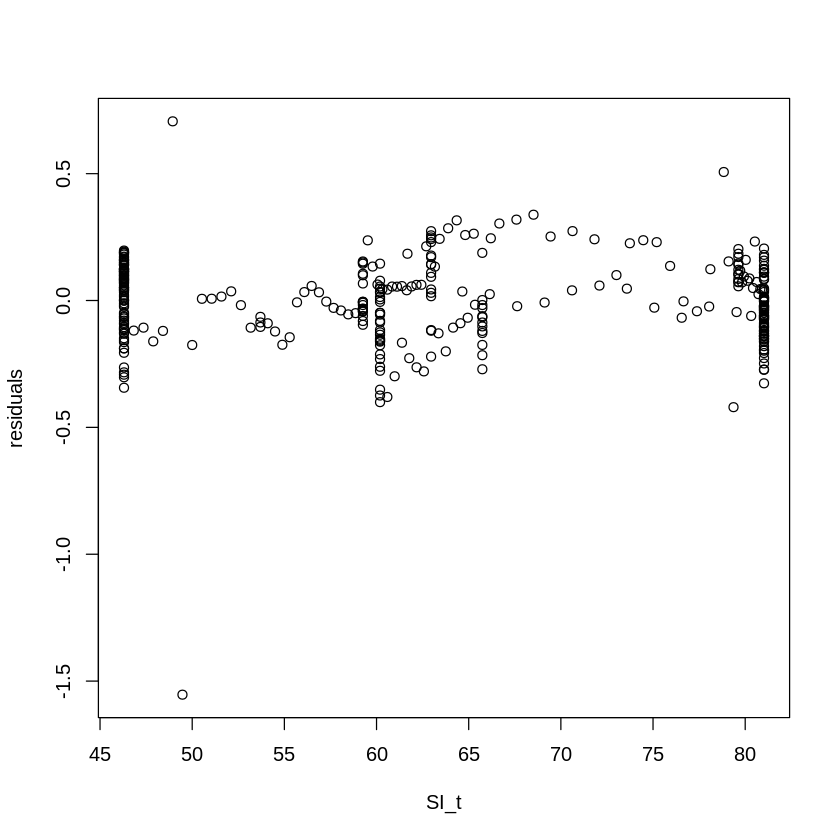

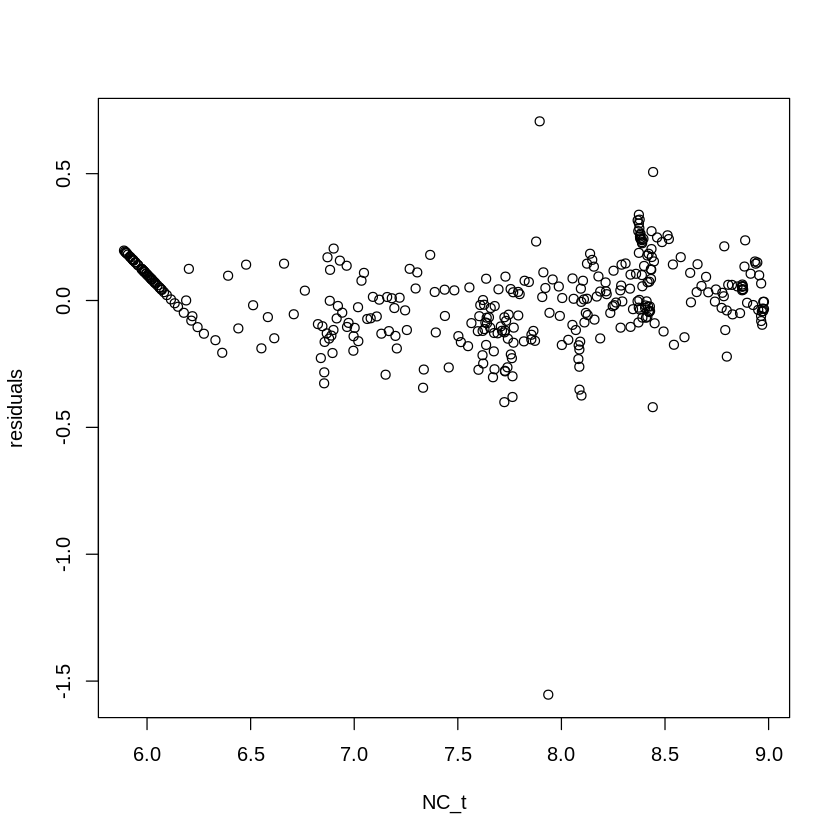

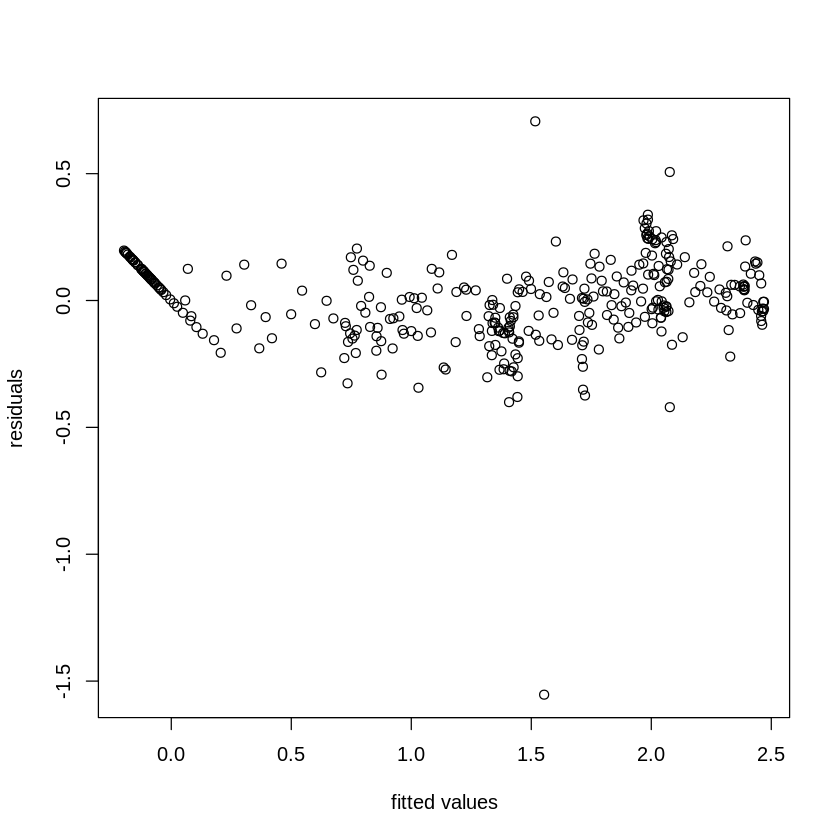

In [13]:
res <- residuals(modelo_init)
yhat <- fitted(modelo_init)
plot(data$SI_t, res, xlab = "SI_t", ylab = "residuals")
plot(log(data$NC_t), res, xlab = "NC_t", ylab = "residuals")
plot(yhat, res, xlab = "fitted values", ylab = "residuals")

#### 3. Dado que el modelo se stima con series de tiempo, es posible que se presenten problemas de autocorrelación. Revise si existe autocorrelación positiva. En caso de que sea así, estime el modelo correcto y realice el intervalo de confianza para cada parámetro (incluyendo el intercepto).